## Install Packages

In [1]:
!pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

Requirement already up-to-date: xarray in /usr/local/lib/python3.6/dist-packages (0.14.1)
     |████████████████████████████████| 3.3MB 4.9MB/s 
     |████████████████████████████████| 317kB 45.7MB/s 
     |████████████████████████████████| 3.8MB 54.0MB/s 
  Created wheel for zarr: filename=zarr-2.4.0-cp36-none-any.whl size=127068 sha256=e903f89091ed48c0d6e0a65a91bd6f0e76dde8f5ff30dbe1f86393b0fb698ae8
  Stored in directory: /root/.cache/pip/wheels/e1/5b/25/24c685604b91139aba00a5b6299b53e7a0661f737f27782559
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5036 sha256=c8ec90cc206ecf760ab119aa2edef497a282aa9155e1cd00820502f8f3867983
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
  Created wheel for numcodecs: filename=numcodecs-0.6.4-cp36-cp36m-linux_x86_64.whl size=3882657 sha256=4e0241e49d22792860af55887127bdc9ee7e66c99e189657b565b7c63d4a6b72
  Stored in directory: /root/.cache/pip/wheels/ca/07/ed/

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

## Browse Available Data

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [0]:
table_id = 'SImon'
activity_id ='ScenarioMIP'
list_variable_id = ['sithick', 'siareas', 'sivols']; y = dict(zip(list_variable_id, ['[m]', '[1e6 Km2]', '[1e3 Km3]'])) #The List of variables we are interested in
list_experiment_id = ['ssp126', 'ssp245', 'ssp585'] #List of experiments we will work on

In [5]:
#Example of how data is structured in the csv
variable_id = list_variable_id[0]
experiment_id = list_experiment_id[2]
df_ta = df.query("table_id == @table_id & variable_id == @variable_id & activity_id== @activity_id & experiment_id == @experiment_id")
df_ta

activity_id  ... dcpp_init_year
215509  ScenarioMIP  ...            NaN
218387  ScenarioMIP  ...            NaN
220402  ScenarioMIP  ...            NaN
220708  ScenarioMIP  ...            NaN
221279  ScenarioMIP  ...            NaN
221336  ScenarioMIP  ...            NaN
221390  ScenarioMIP  ...            NaN
222520  ScenarioMIP  ...            NaN
222599  ScenarioMIP  ...            NaN
222661  ScenarioMIP  ...            NaN
222722  ScenarioMIP  ...            NaN
222784  ScenarioMIP  ...            NaN
223946  ScenarioMIP  ...            NaN
224453  ScenarioMIP  ...            NaN
224611  ScenarioMIP  ...            NaN
224859  ScenarioMIP  ...            NaN
224860  ScenarioMIP  ...            NaN
225133  ScenarioMIP  ...            NaN
225134  ScenarioMIP  ...            NaN
225324  ScenarioMIP  ...            NaN

[20 rows x 10 columns]

## Plotting Data

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


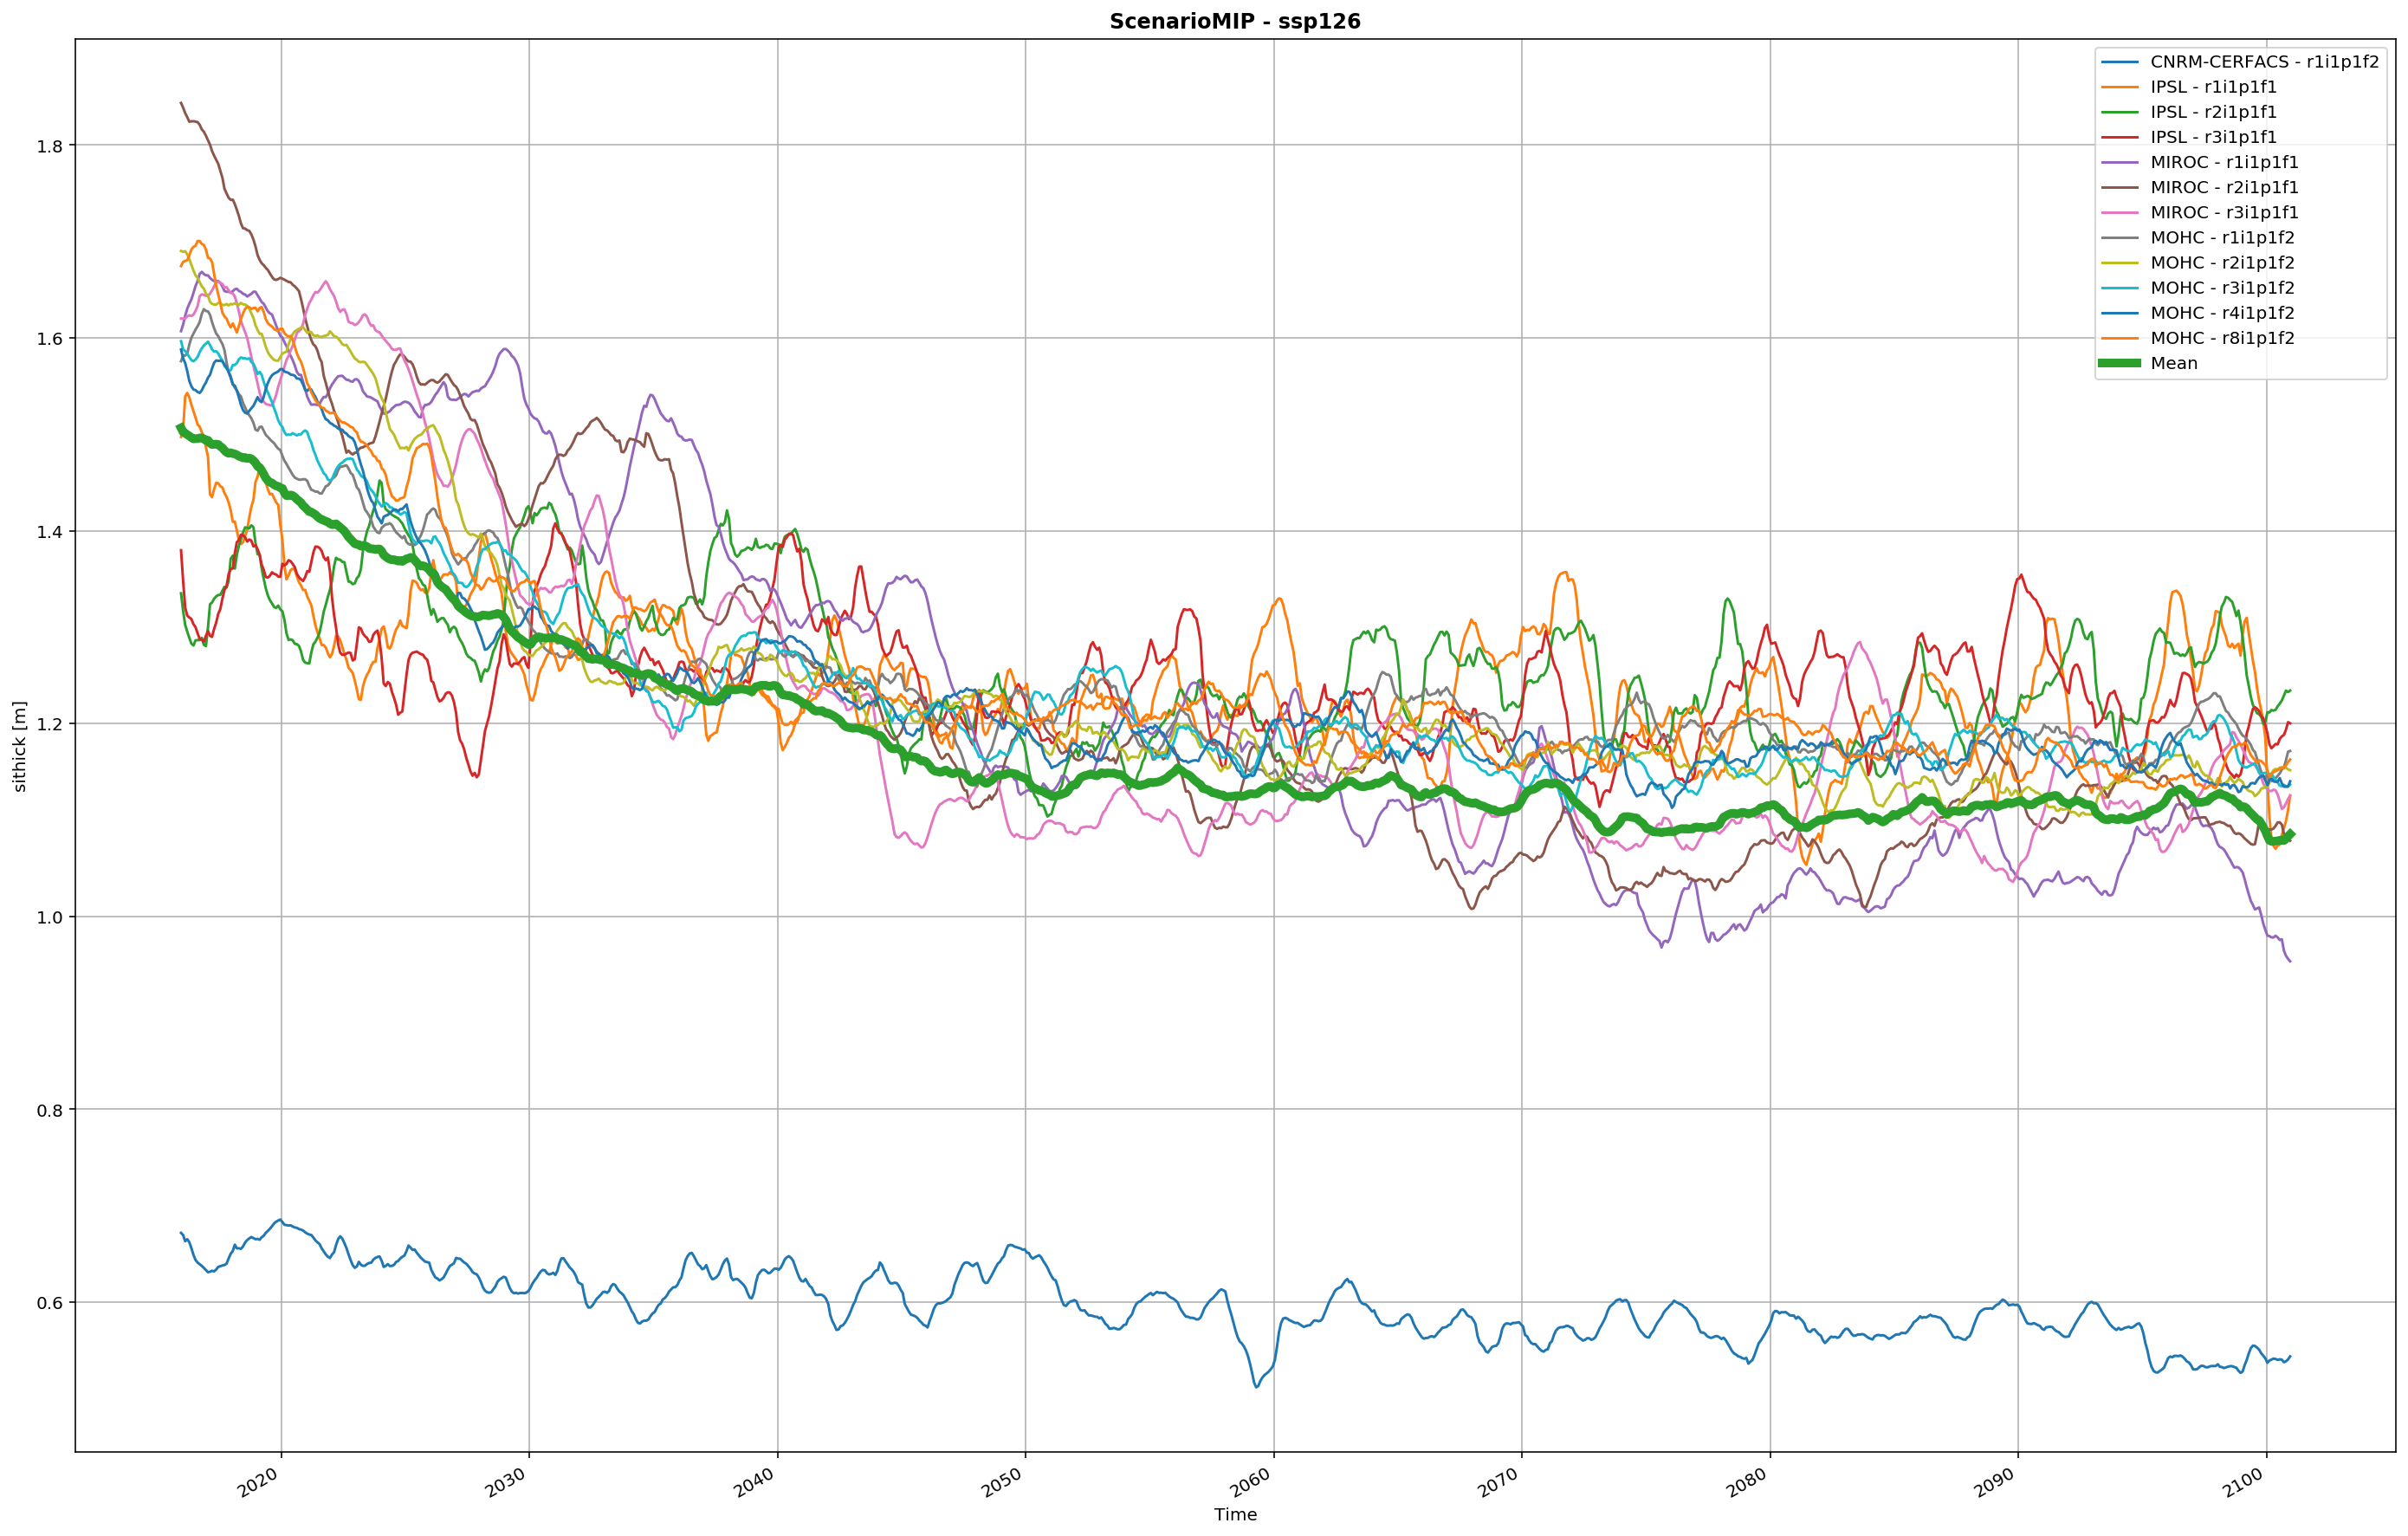

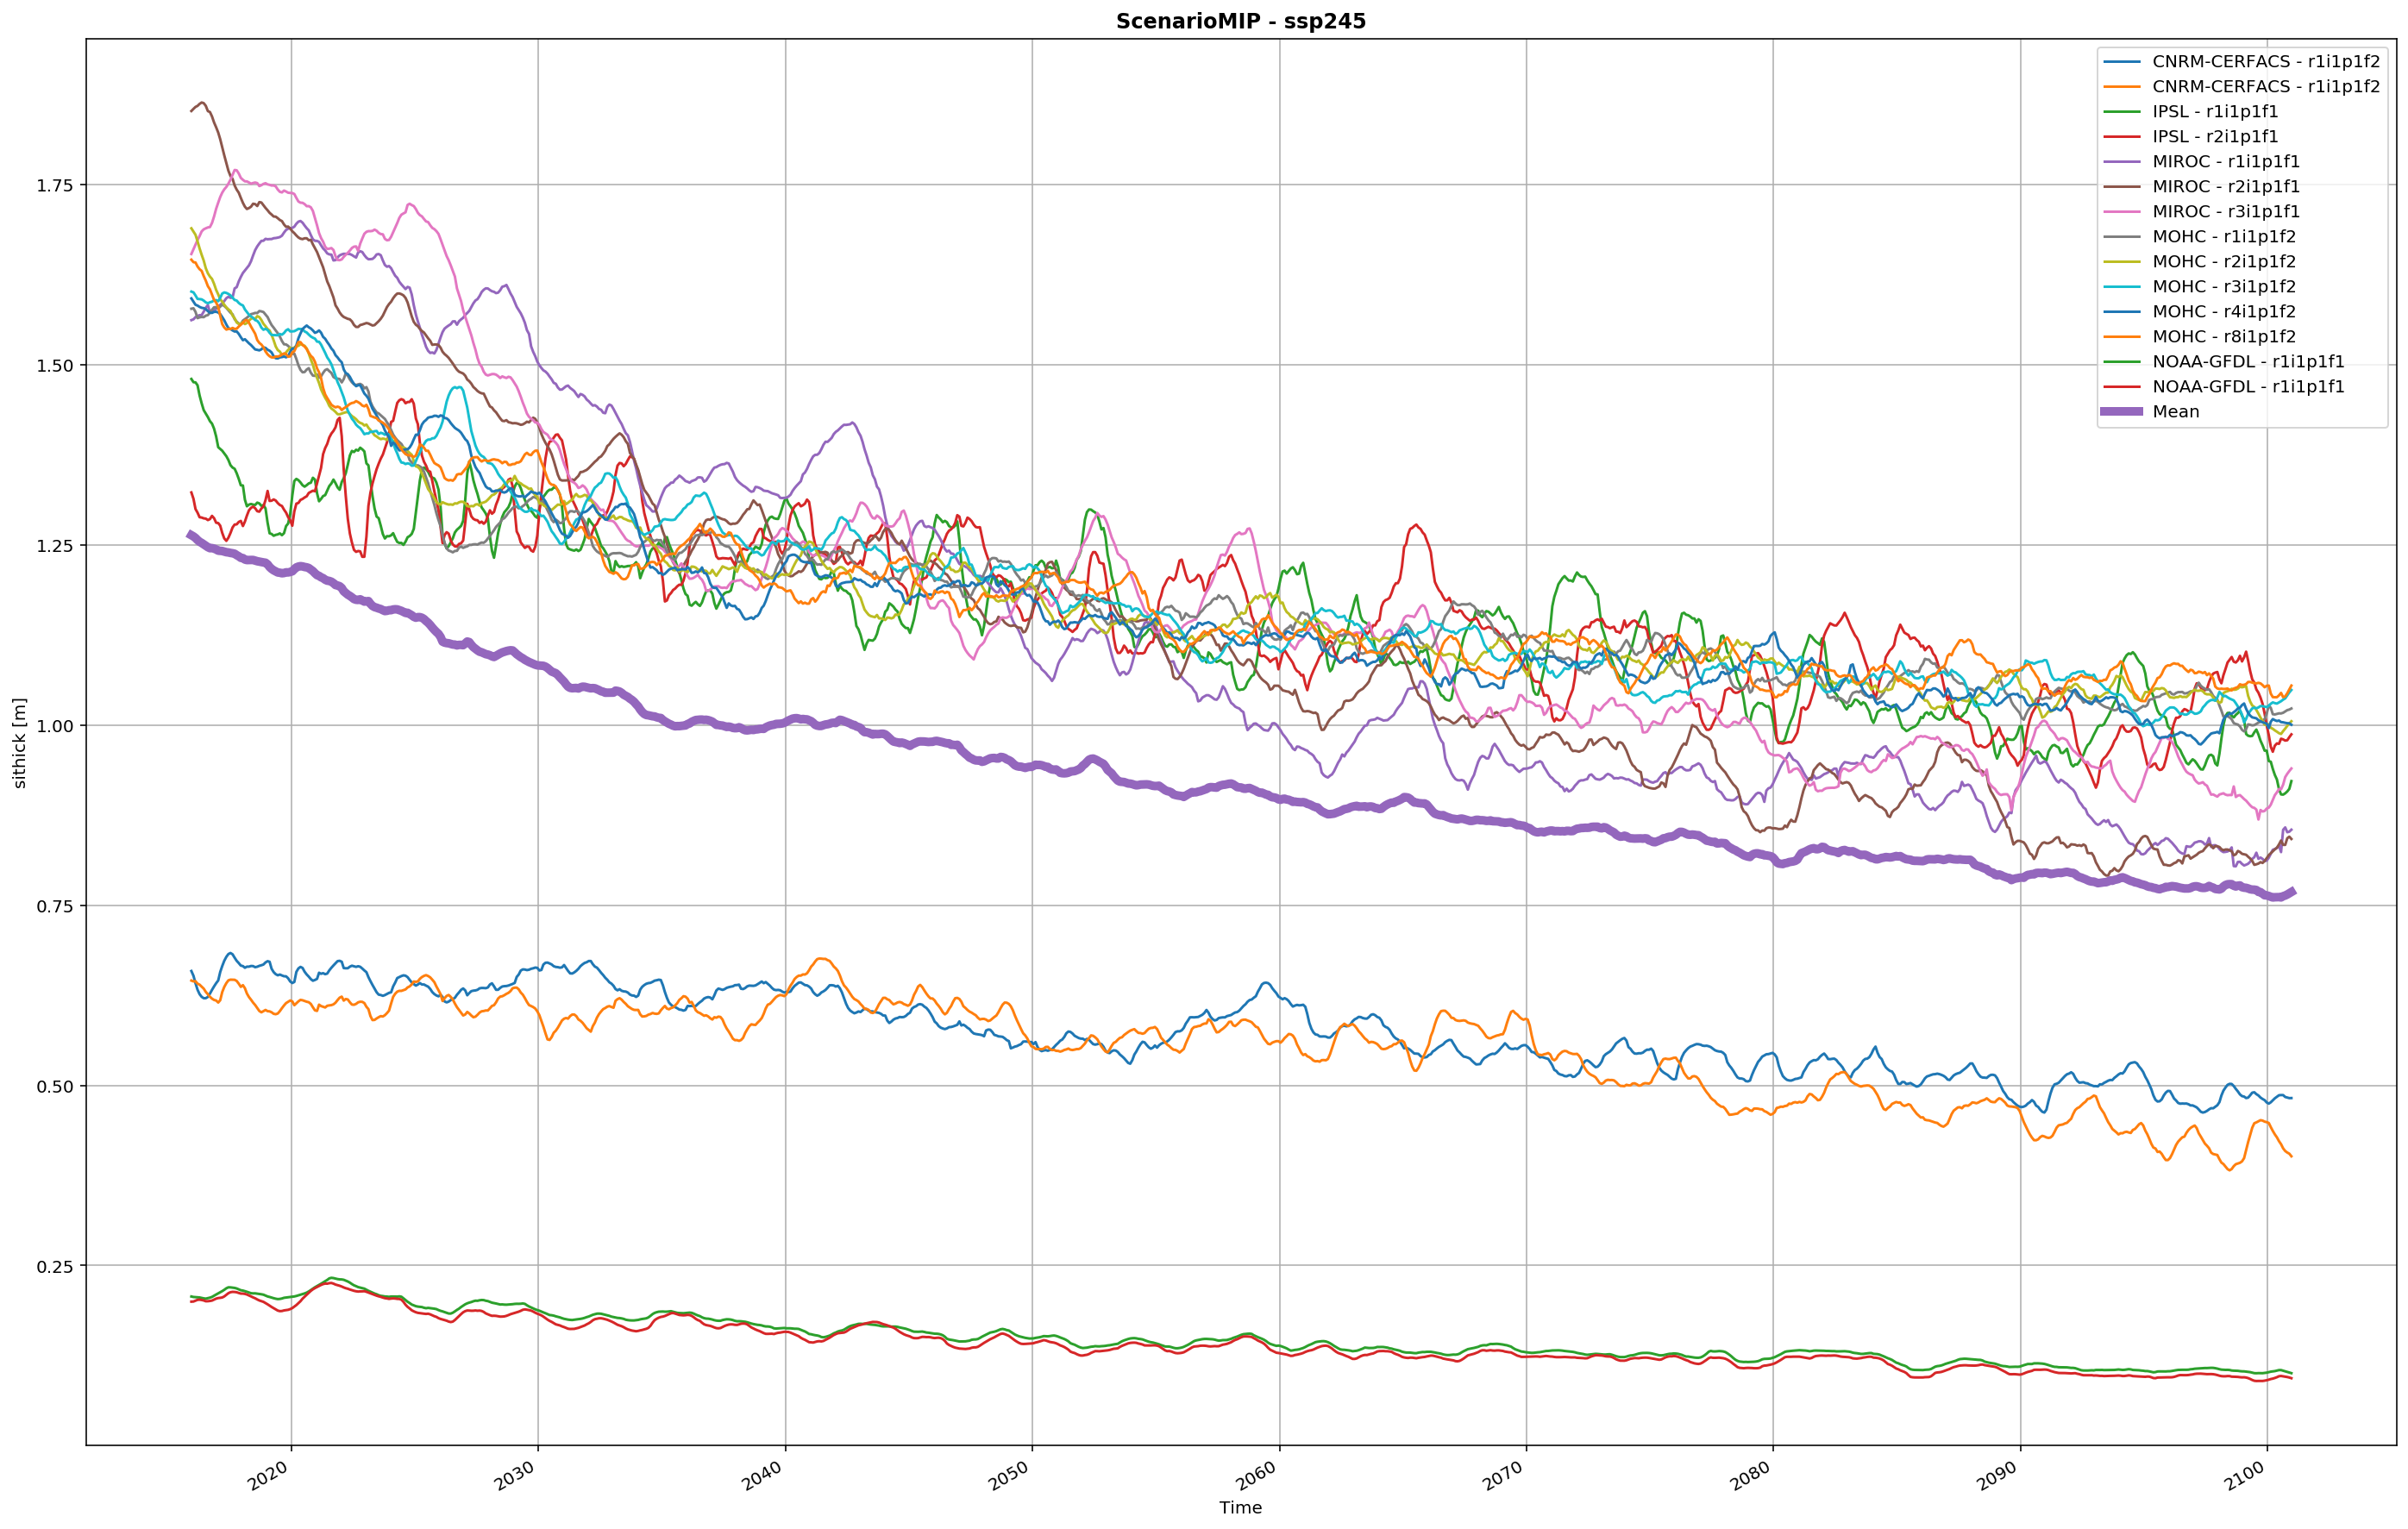

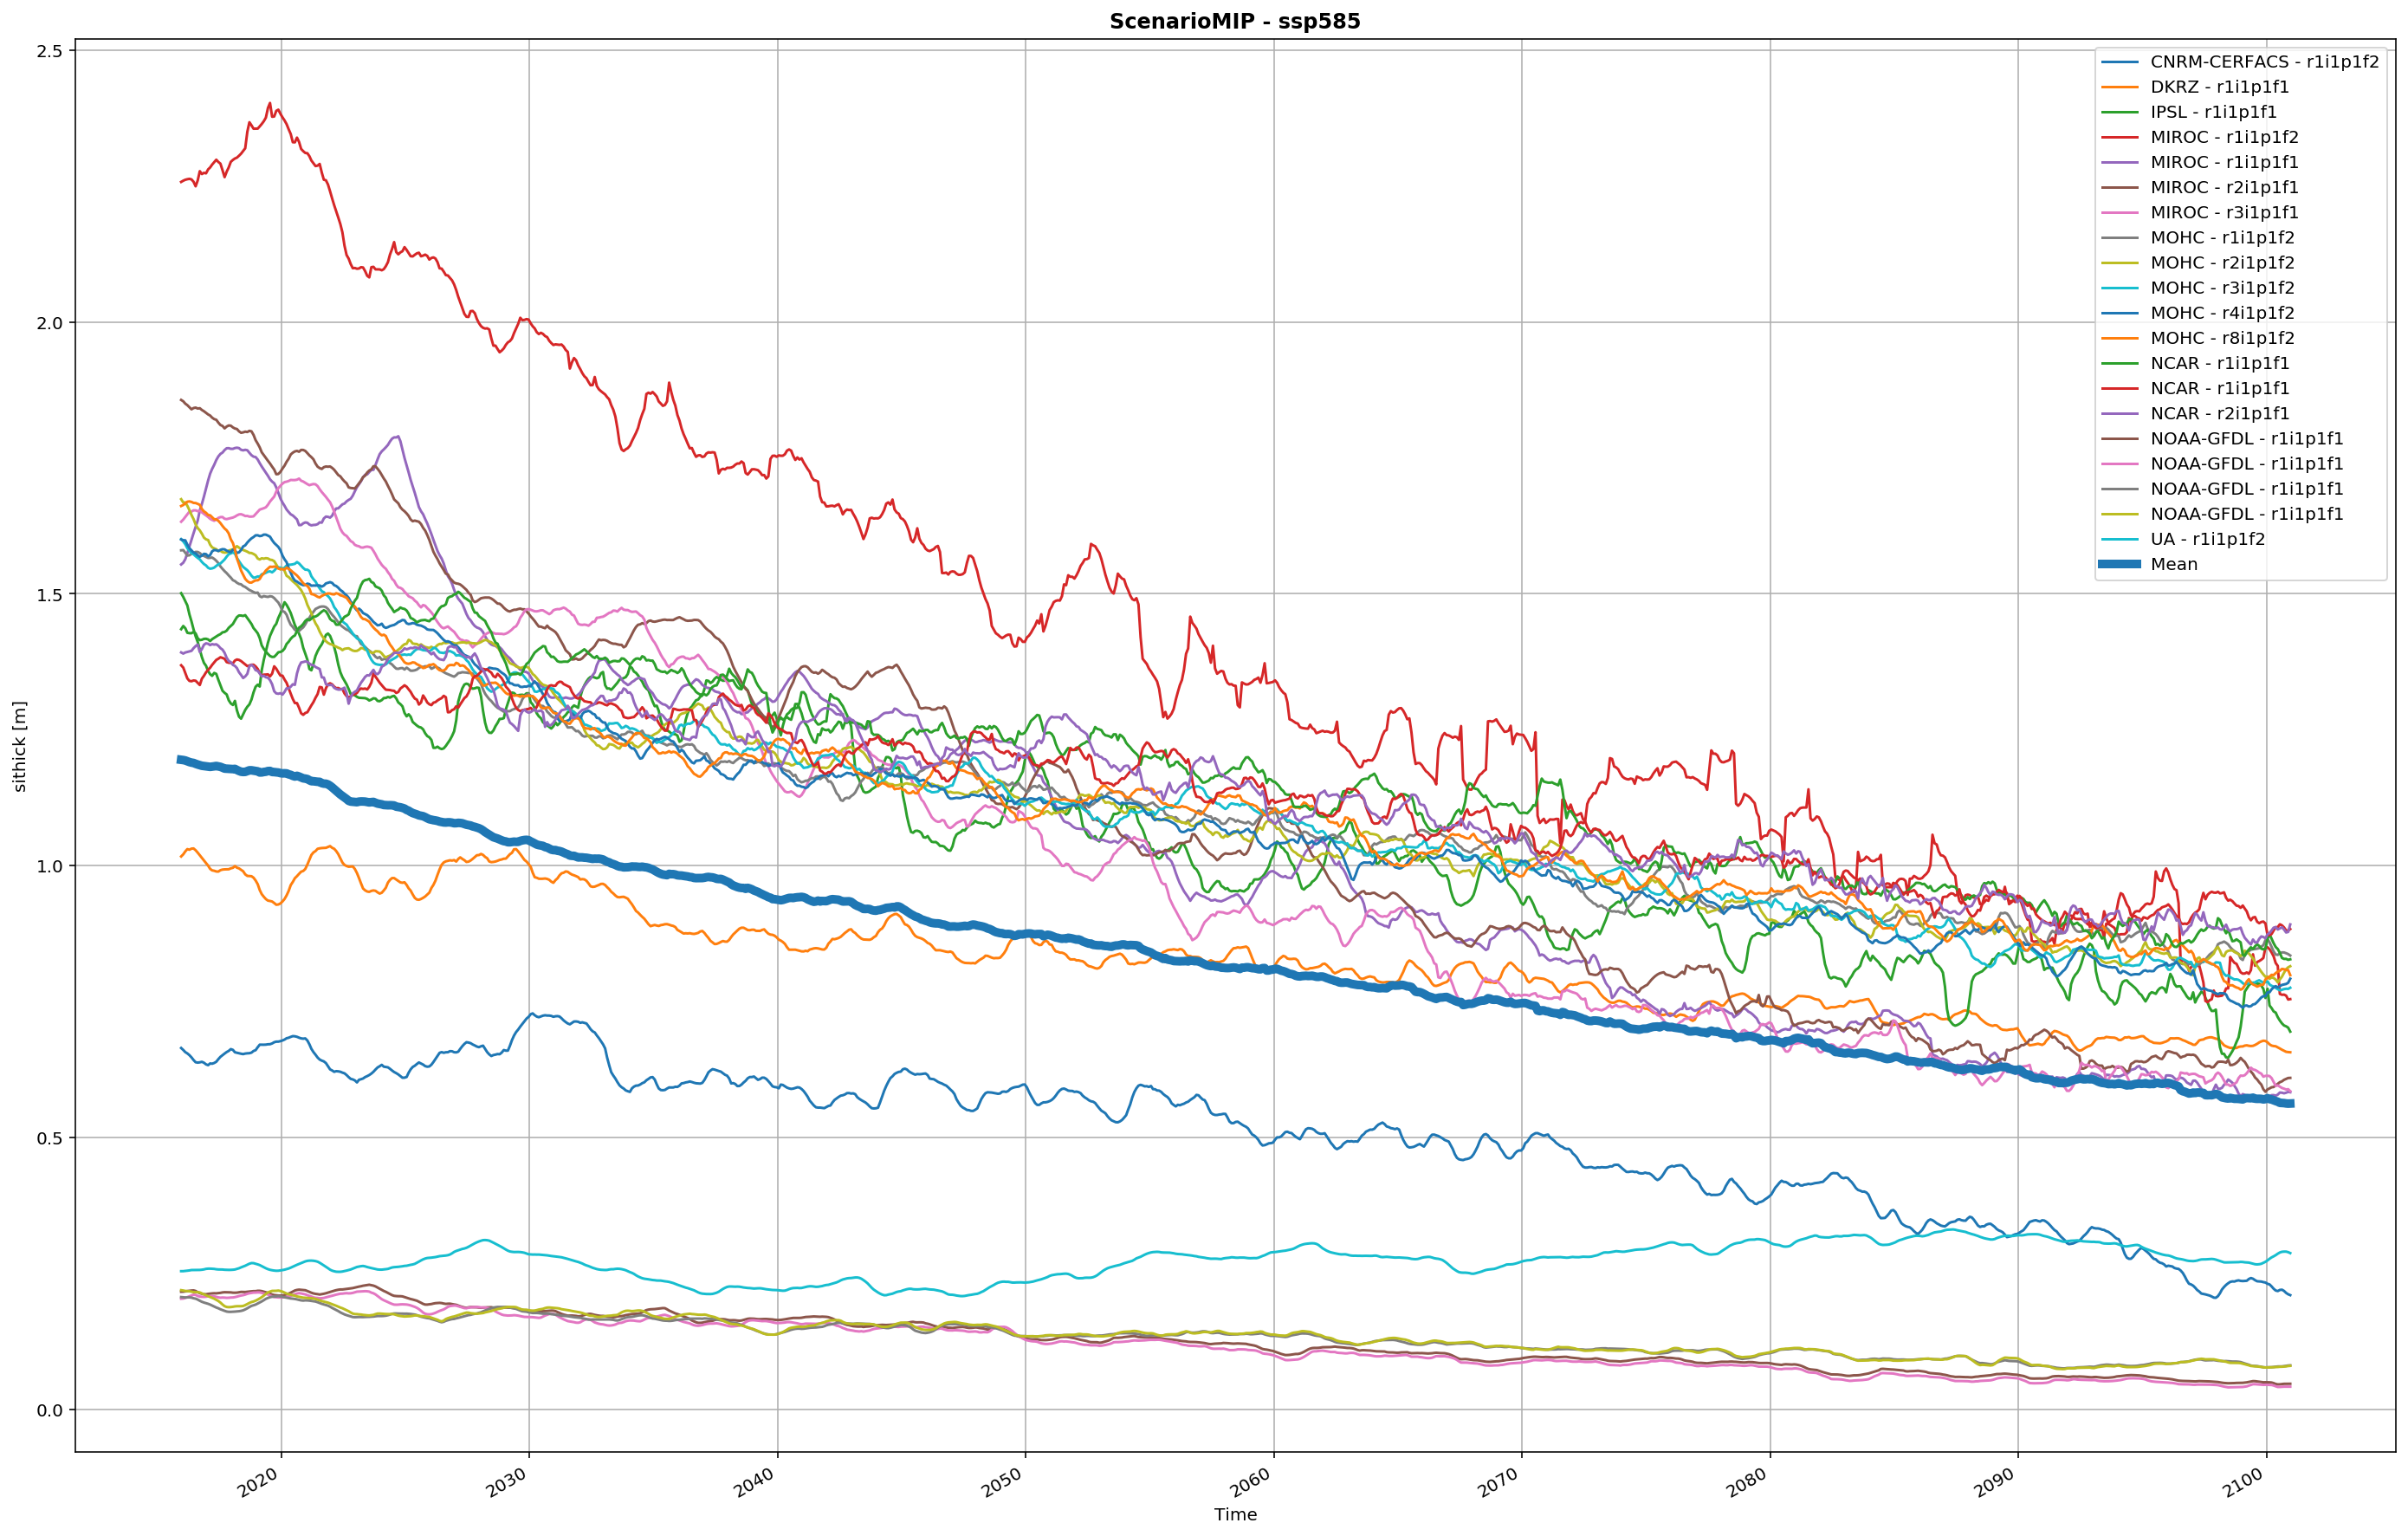

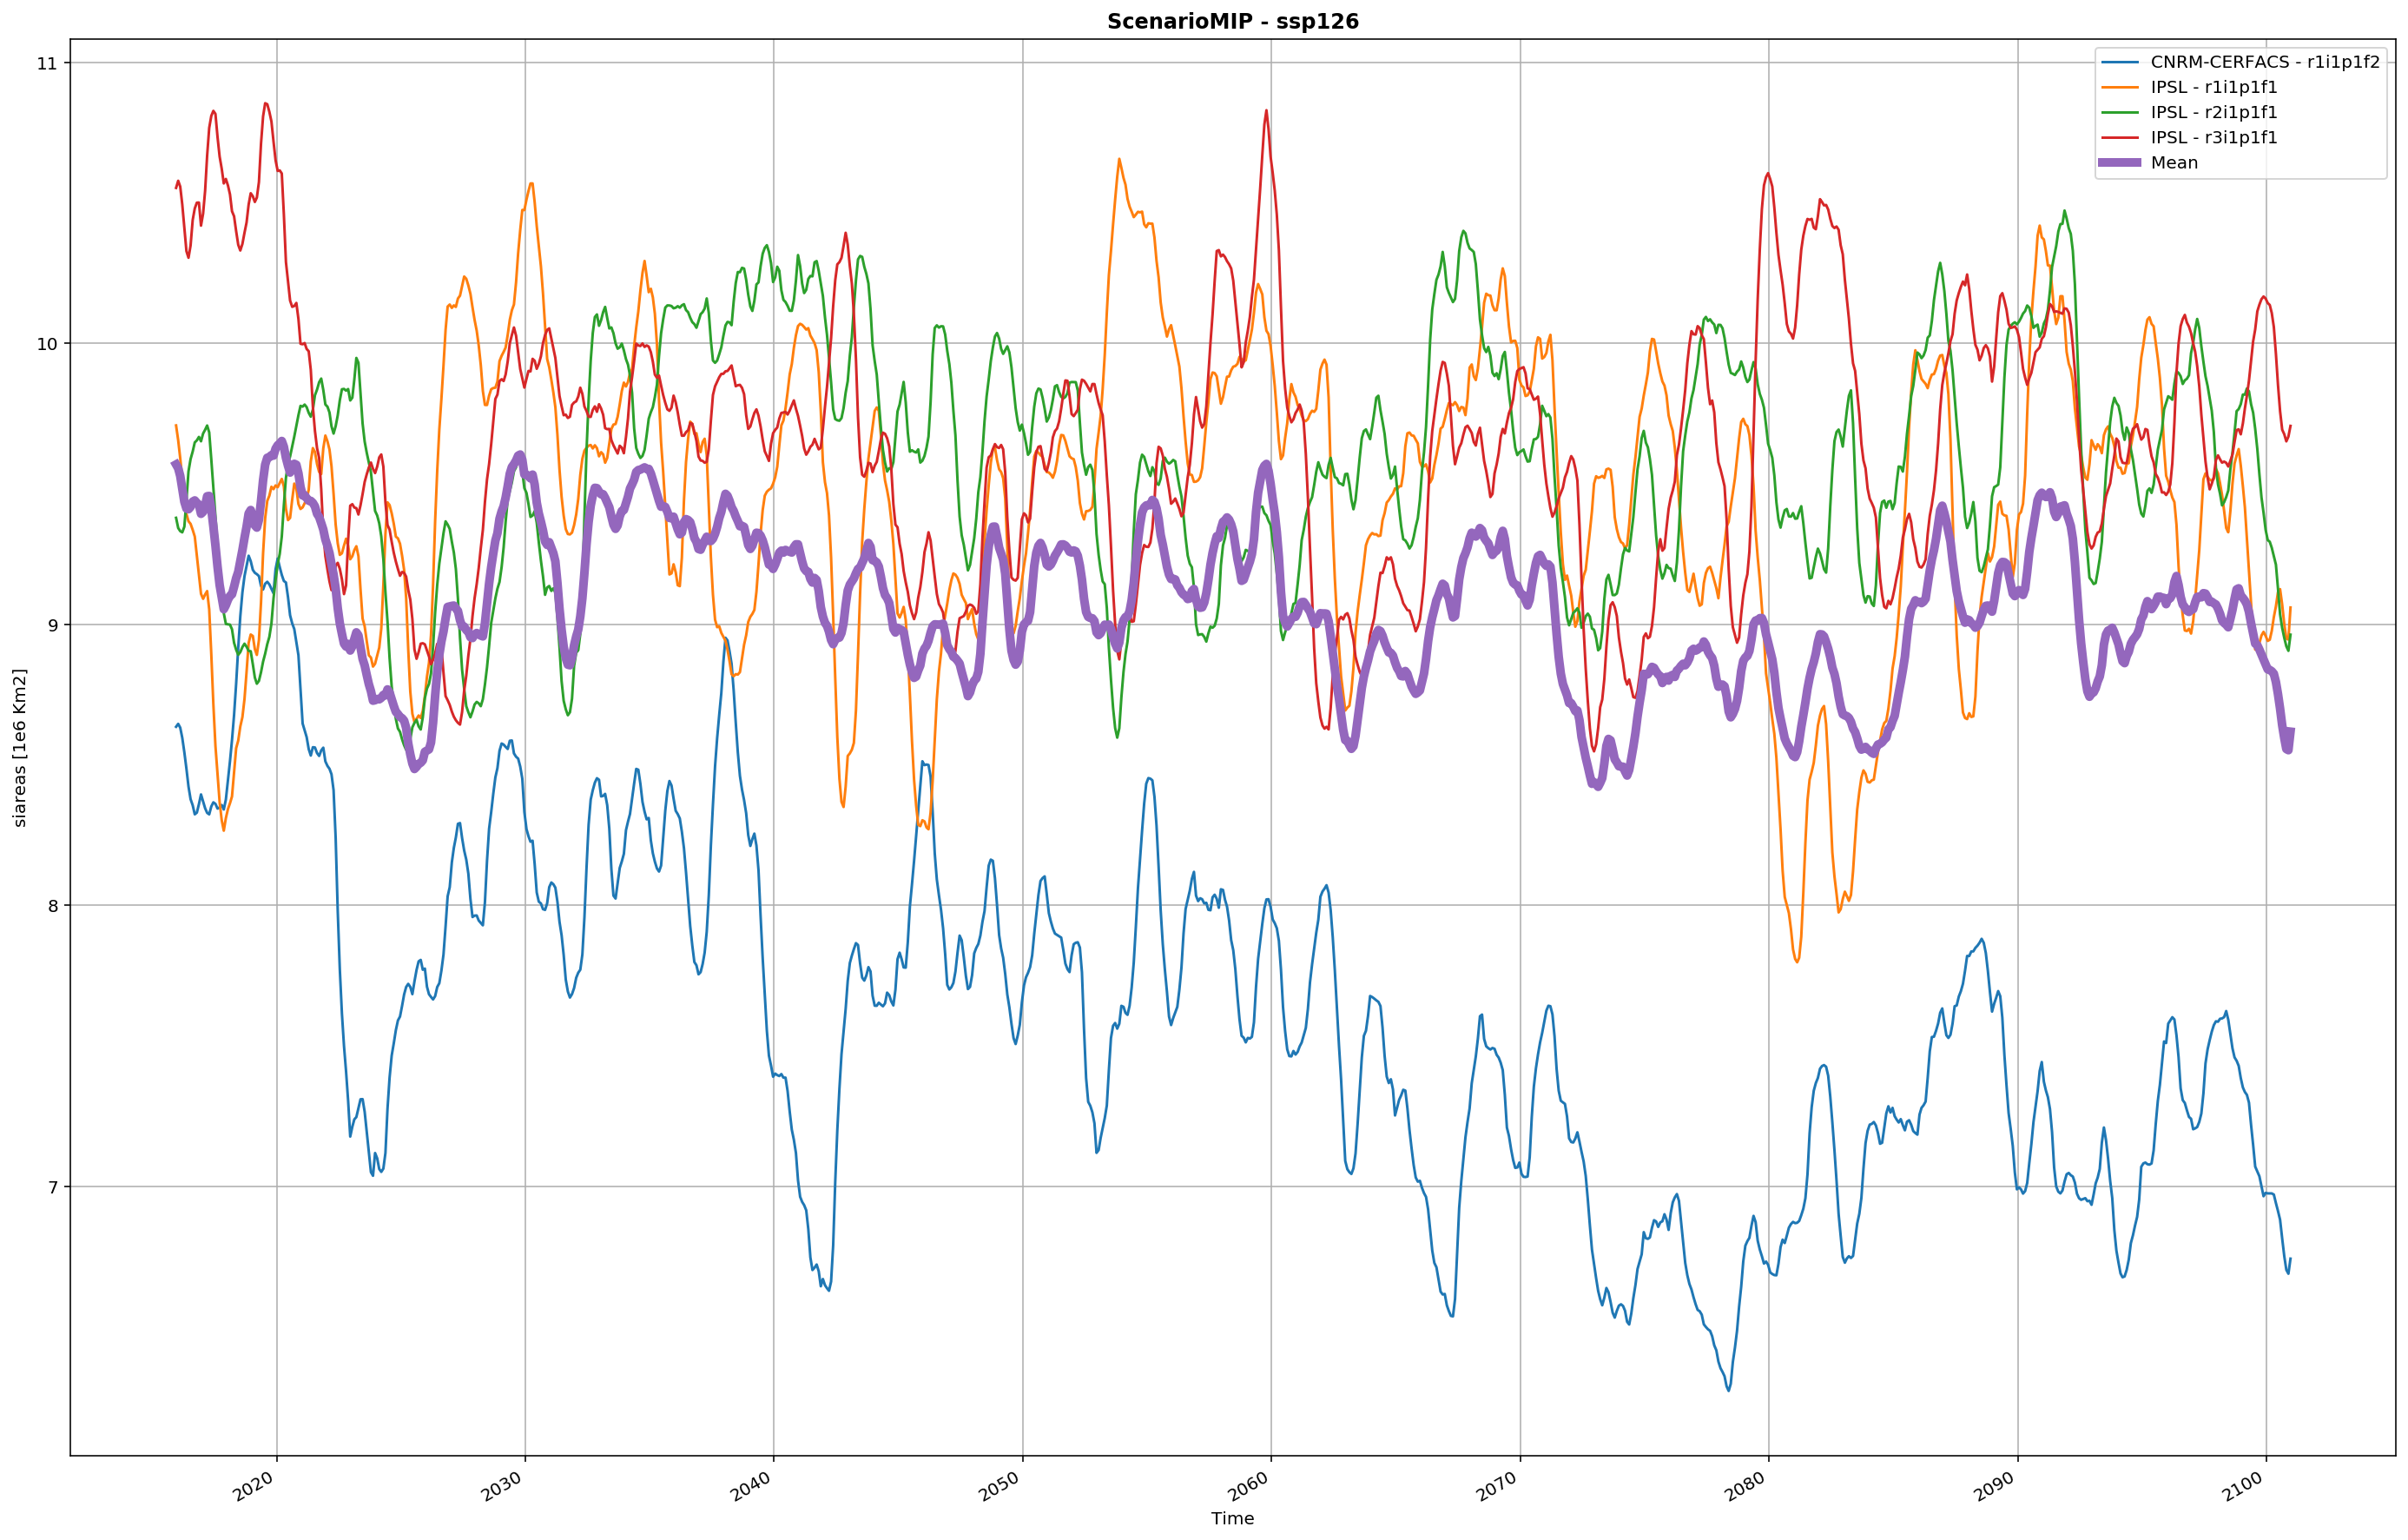

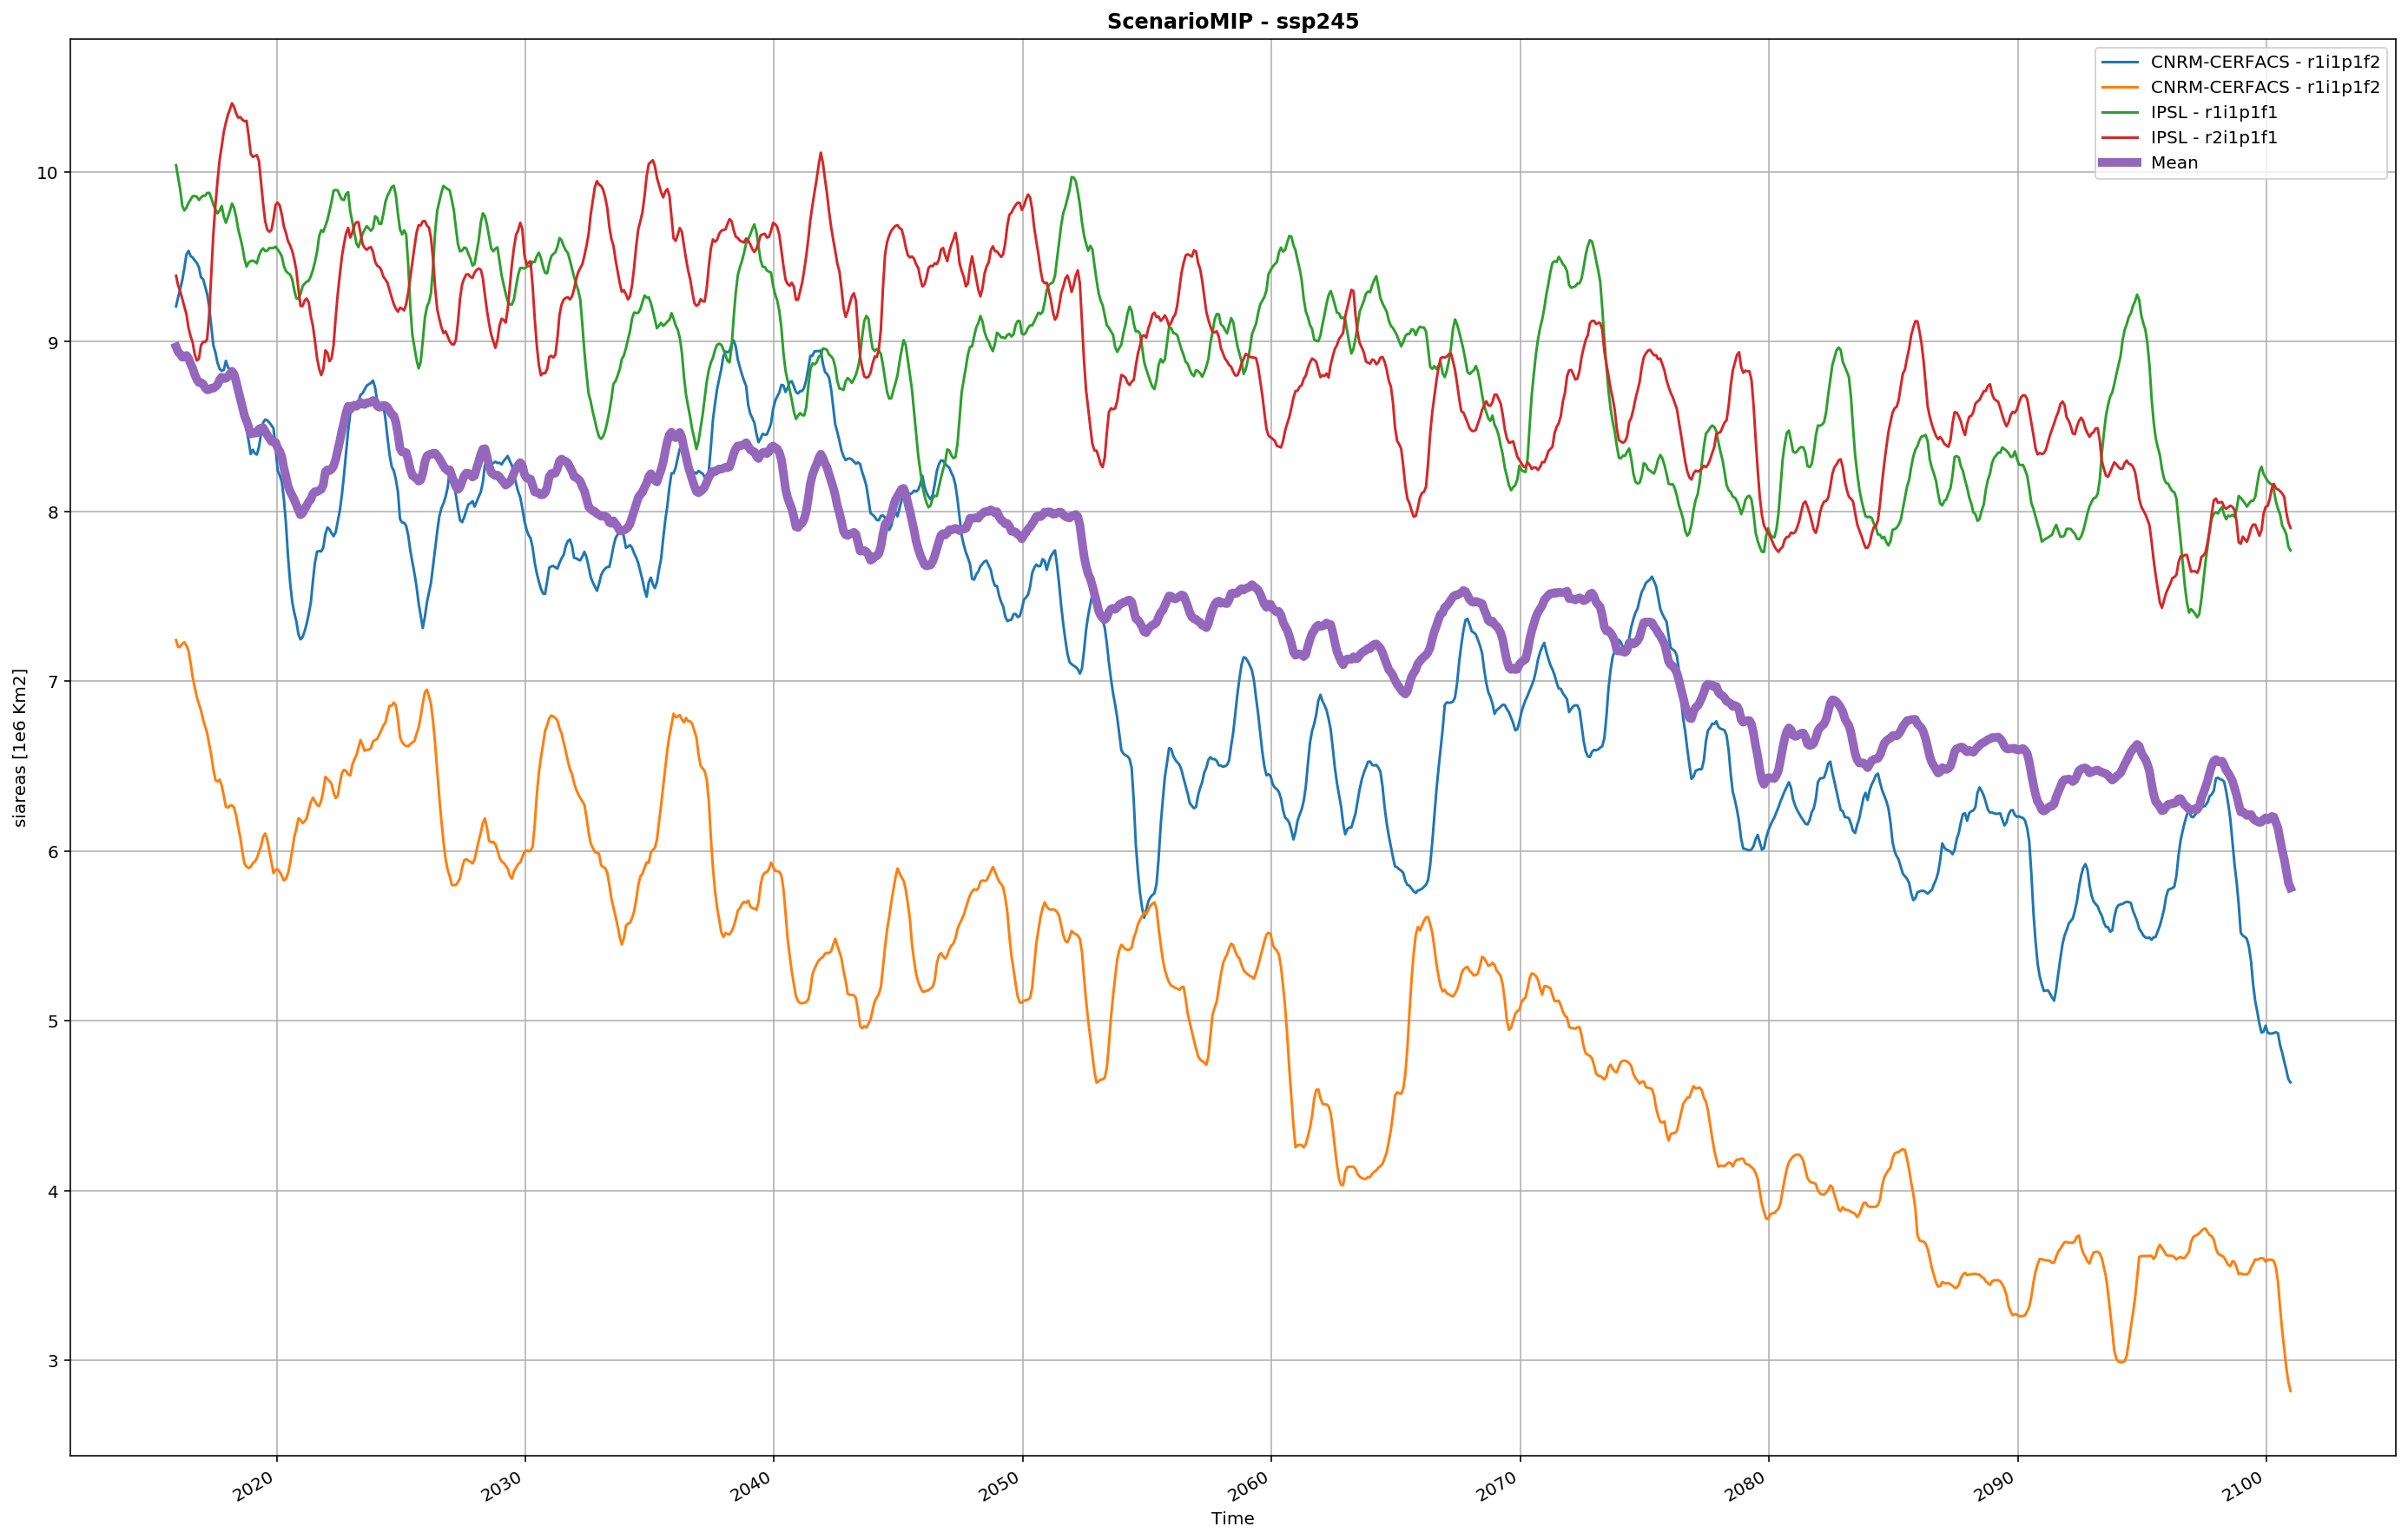

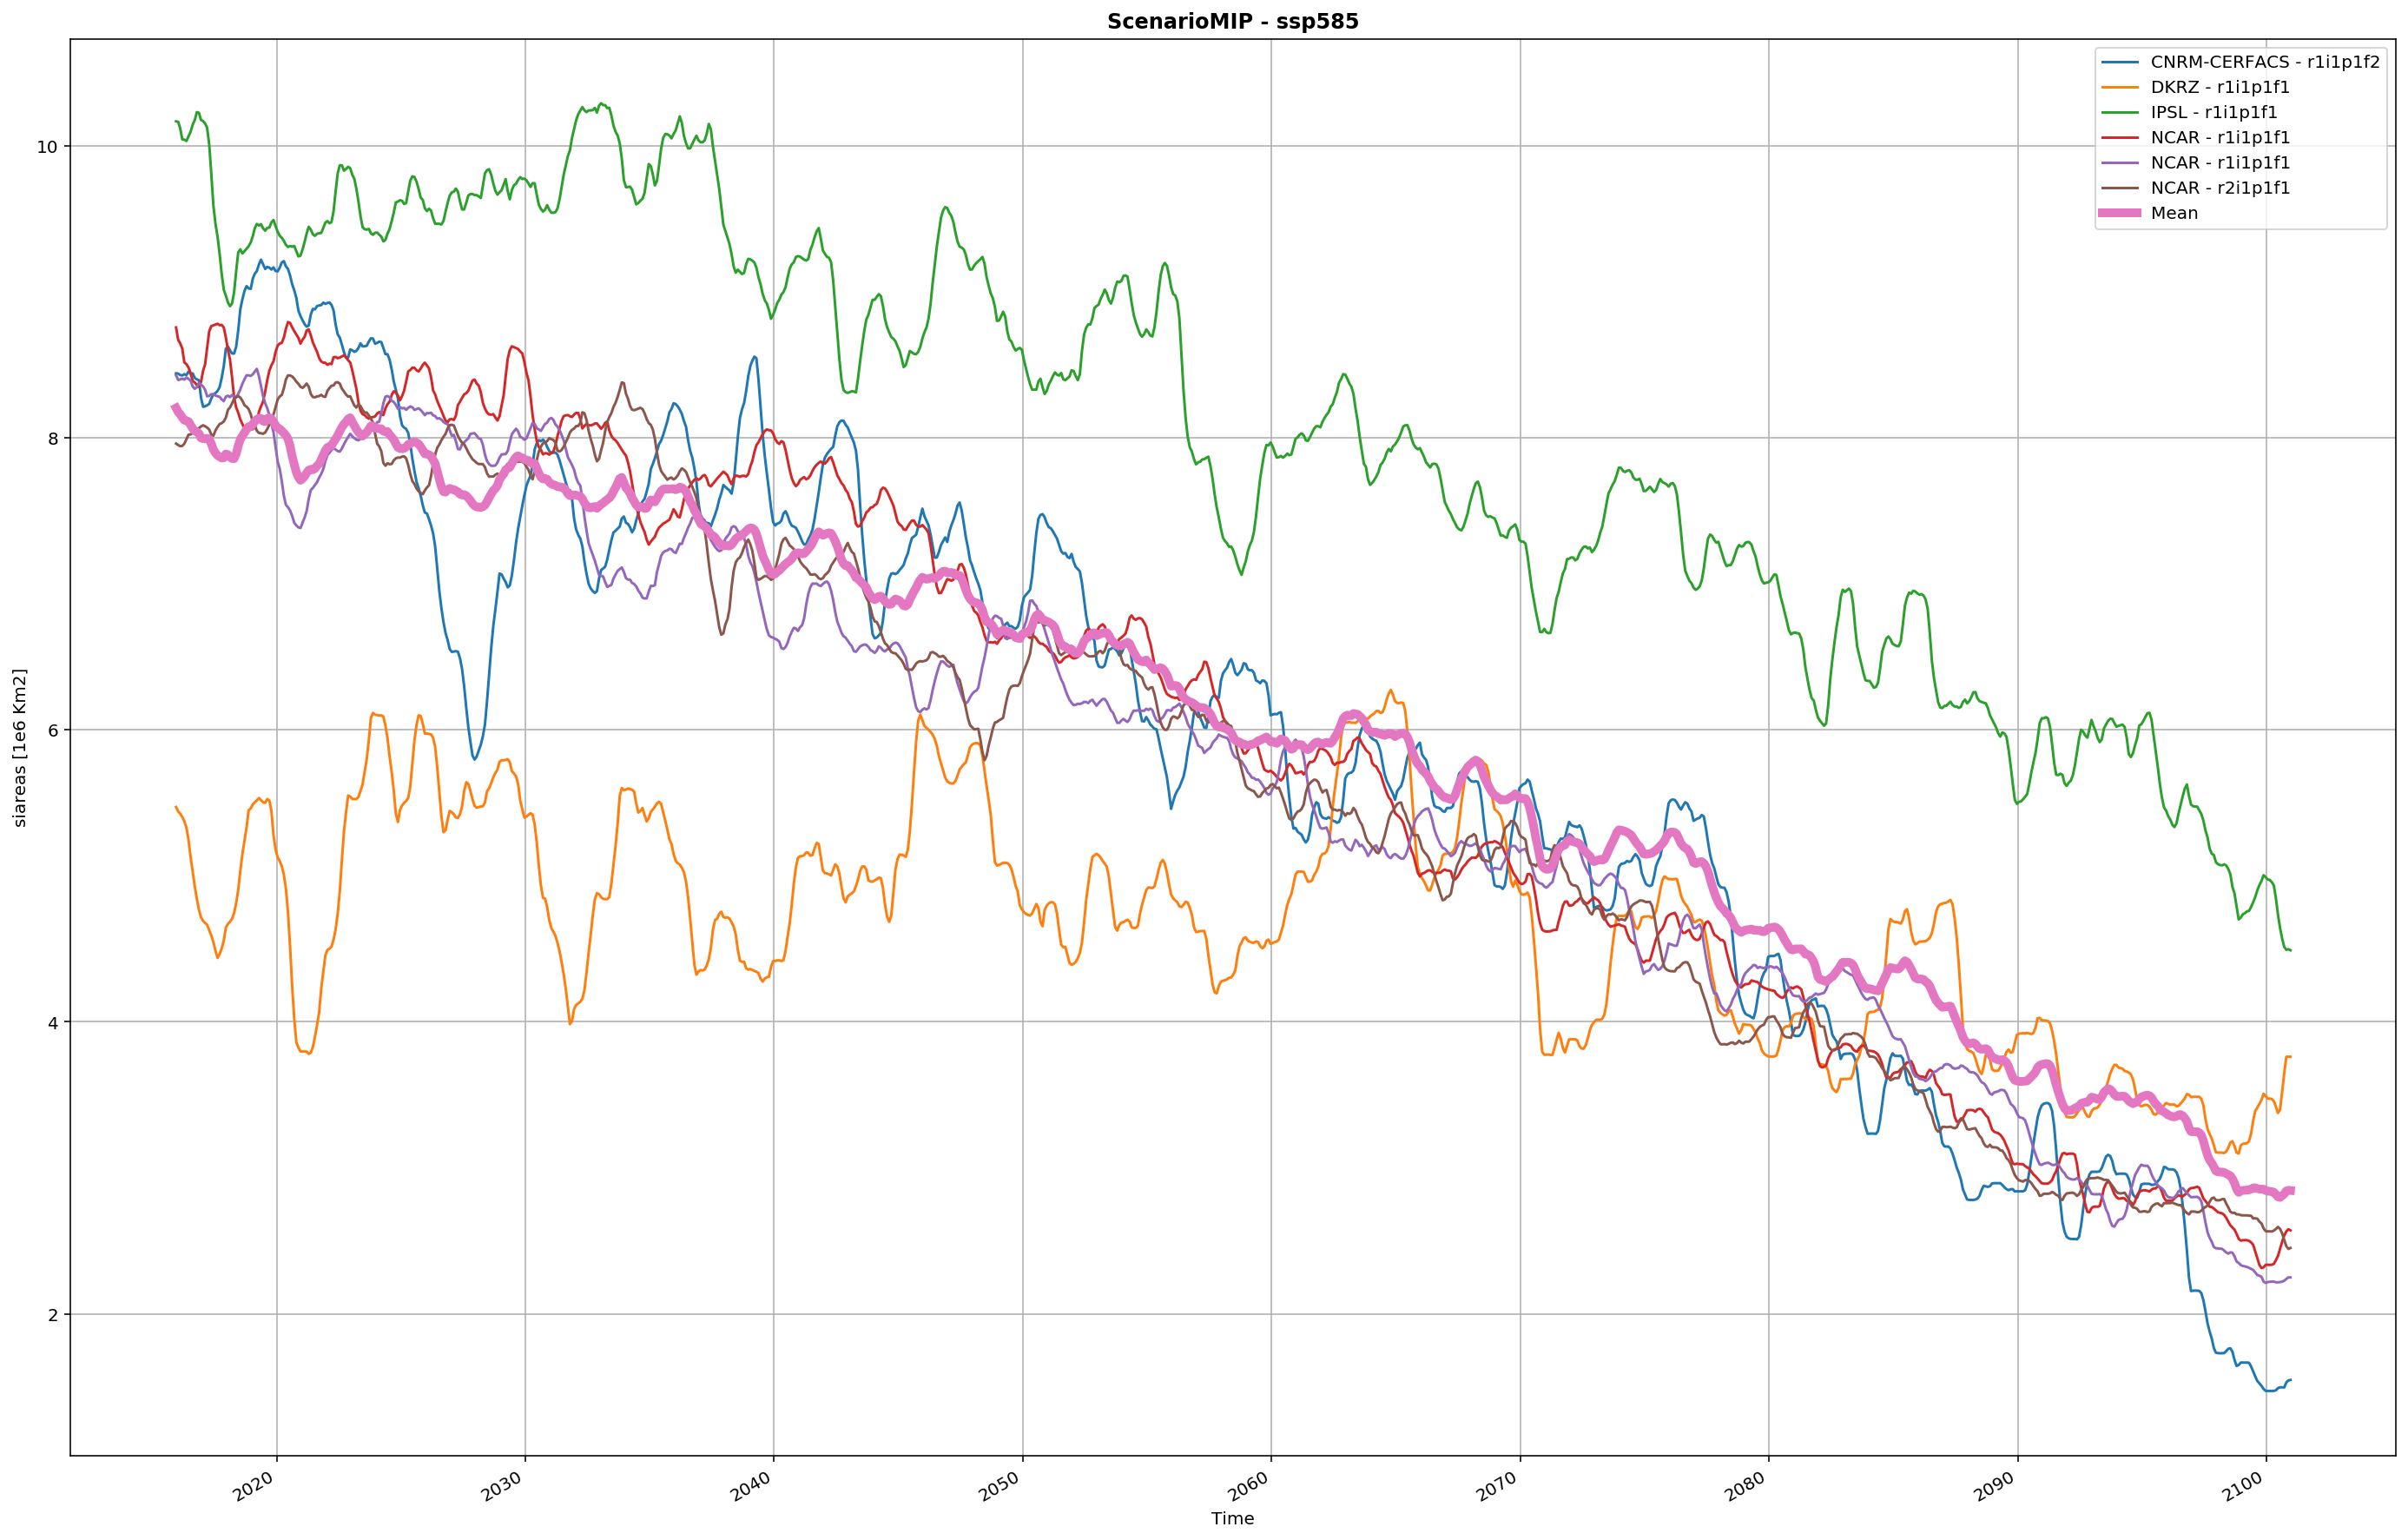

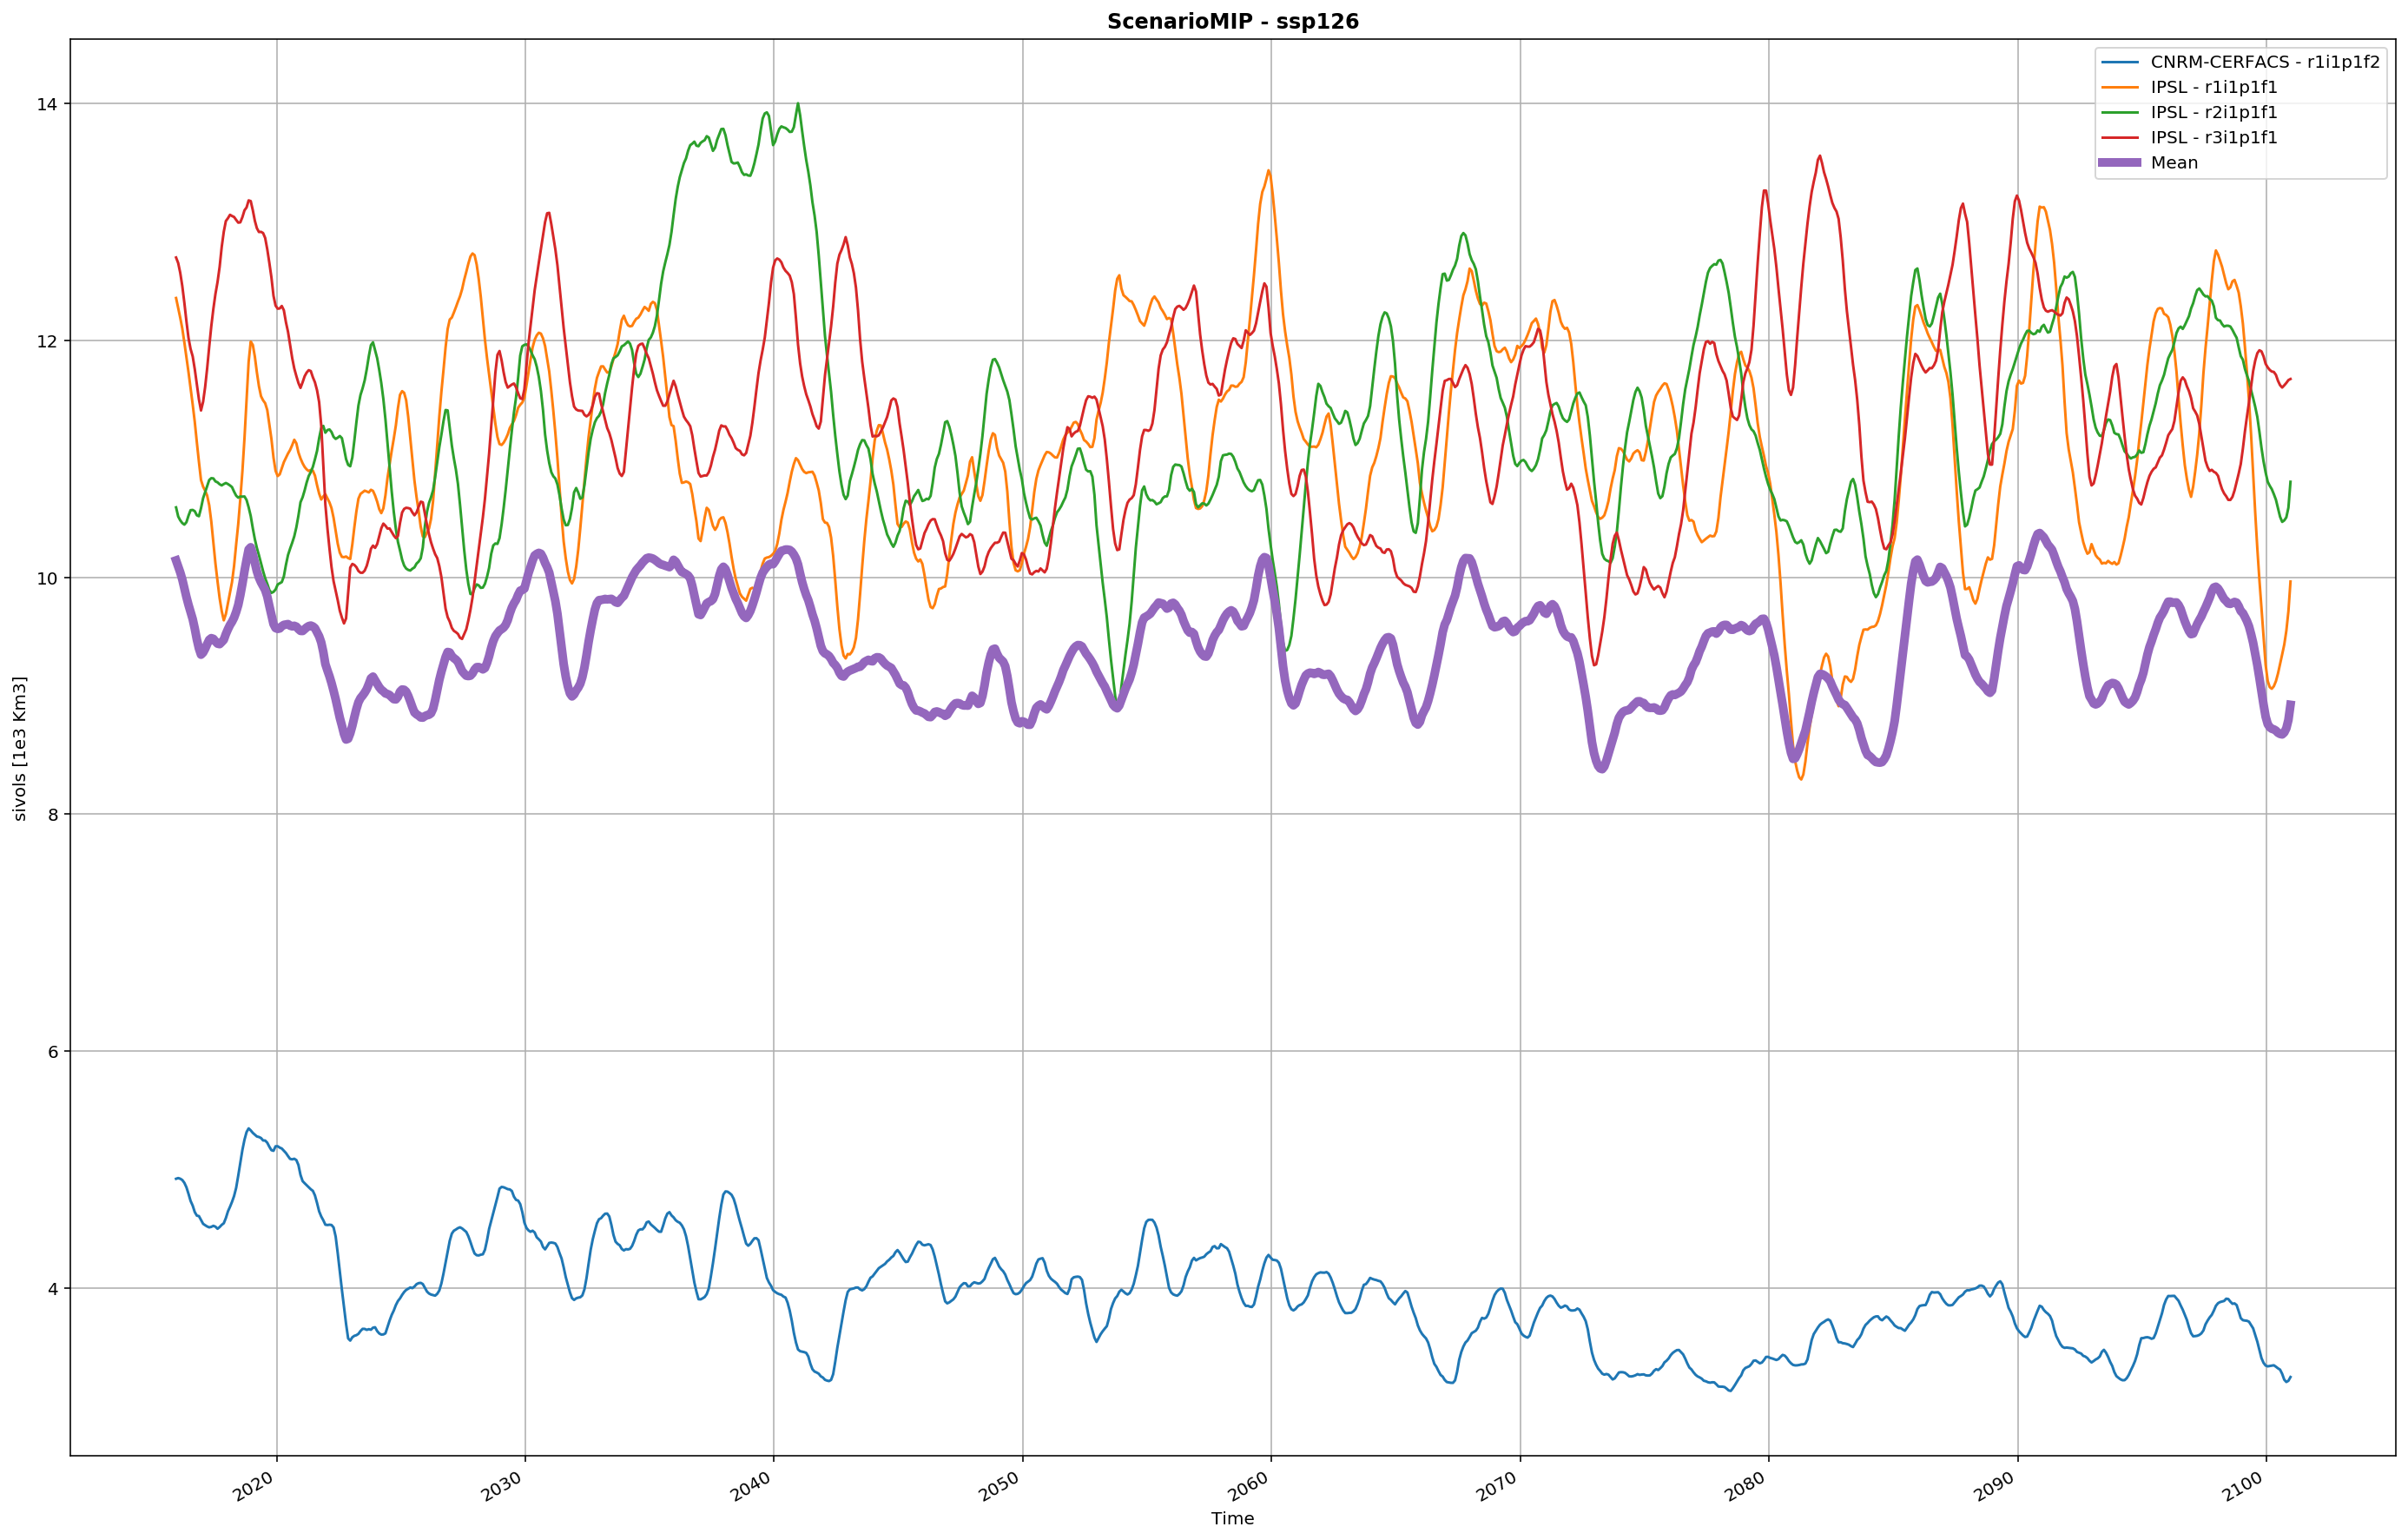

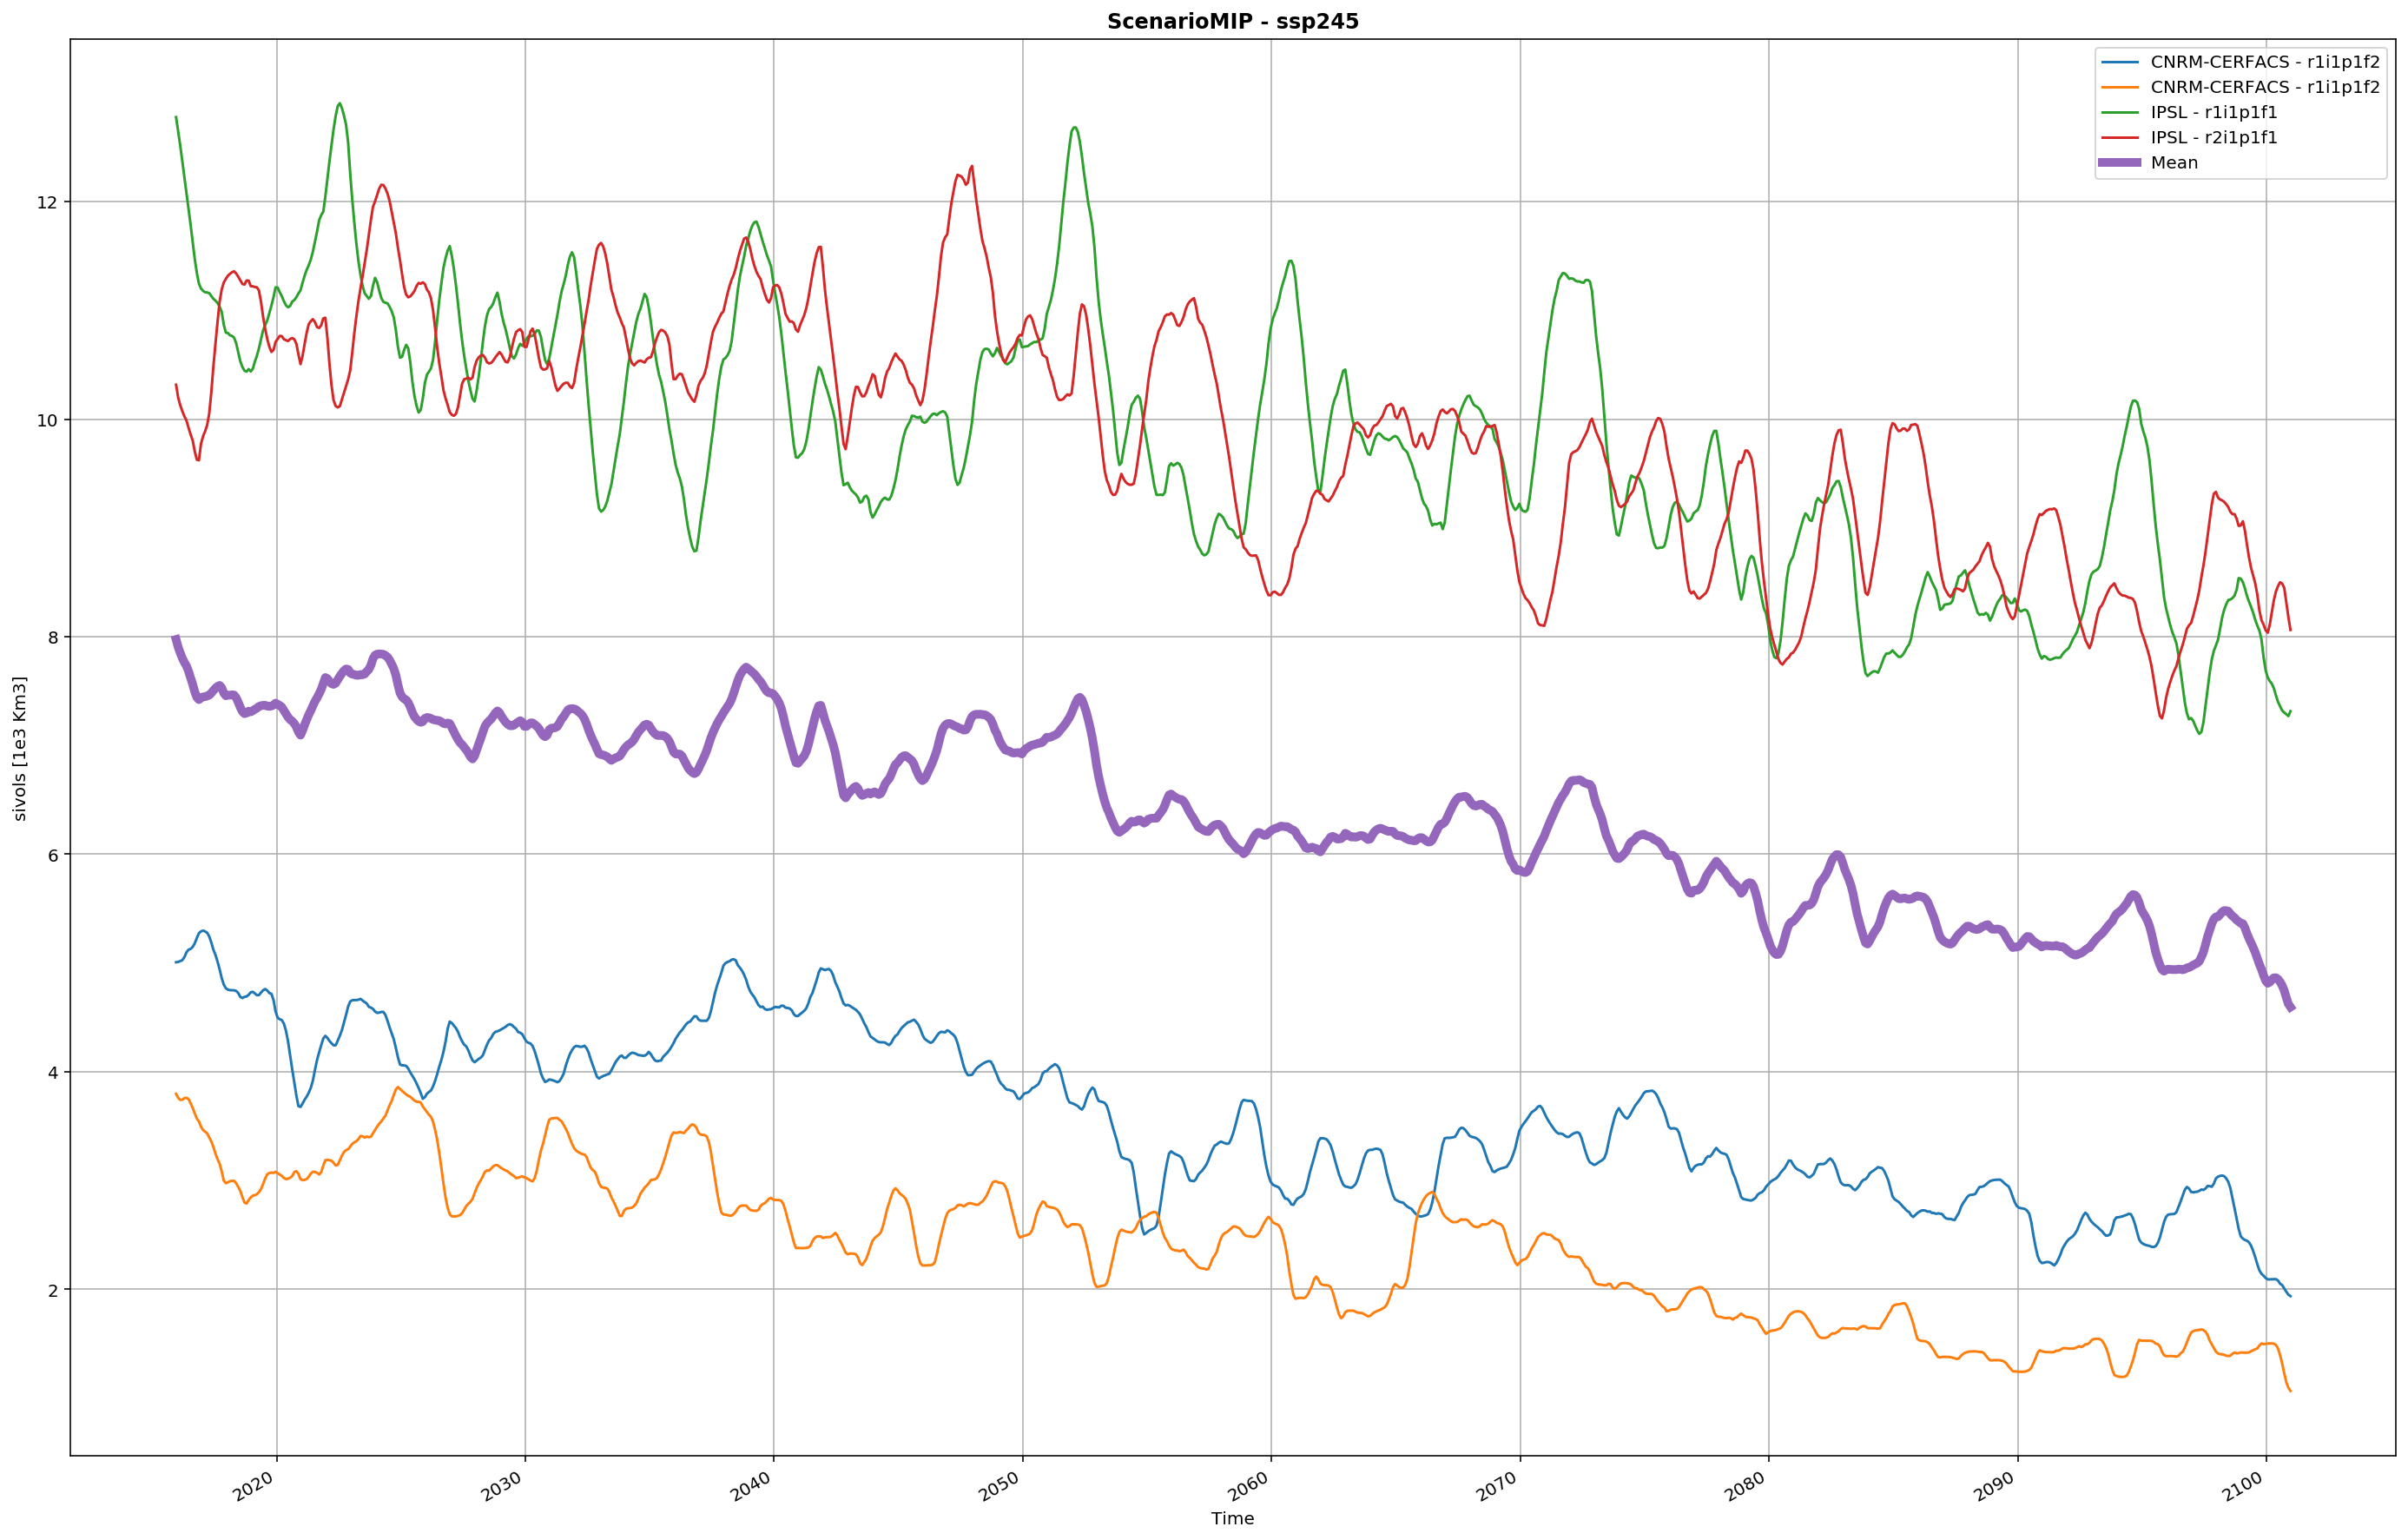

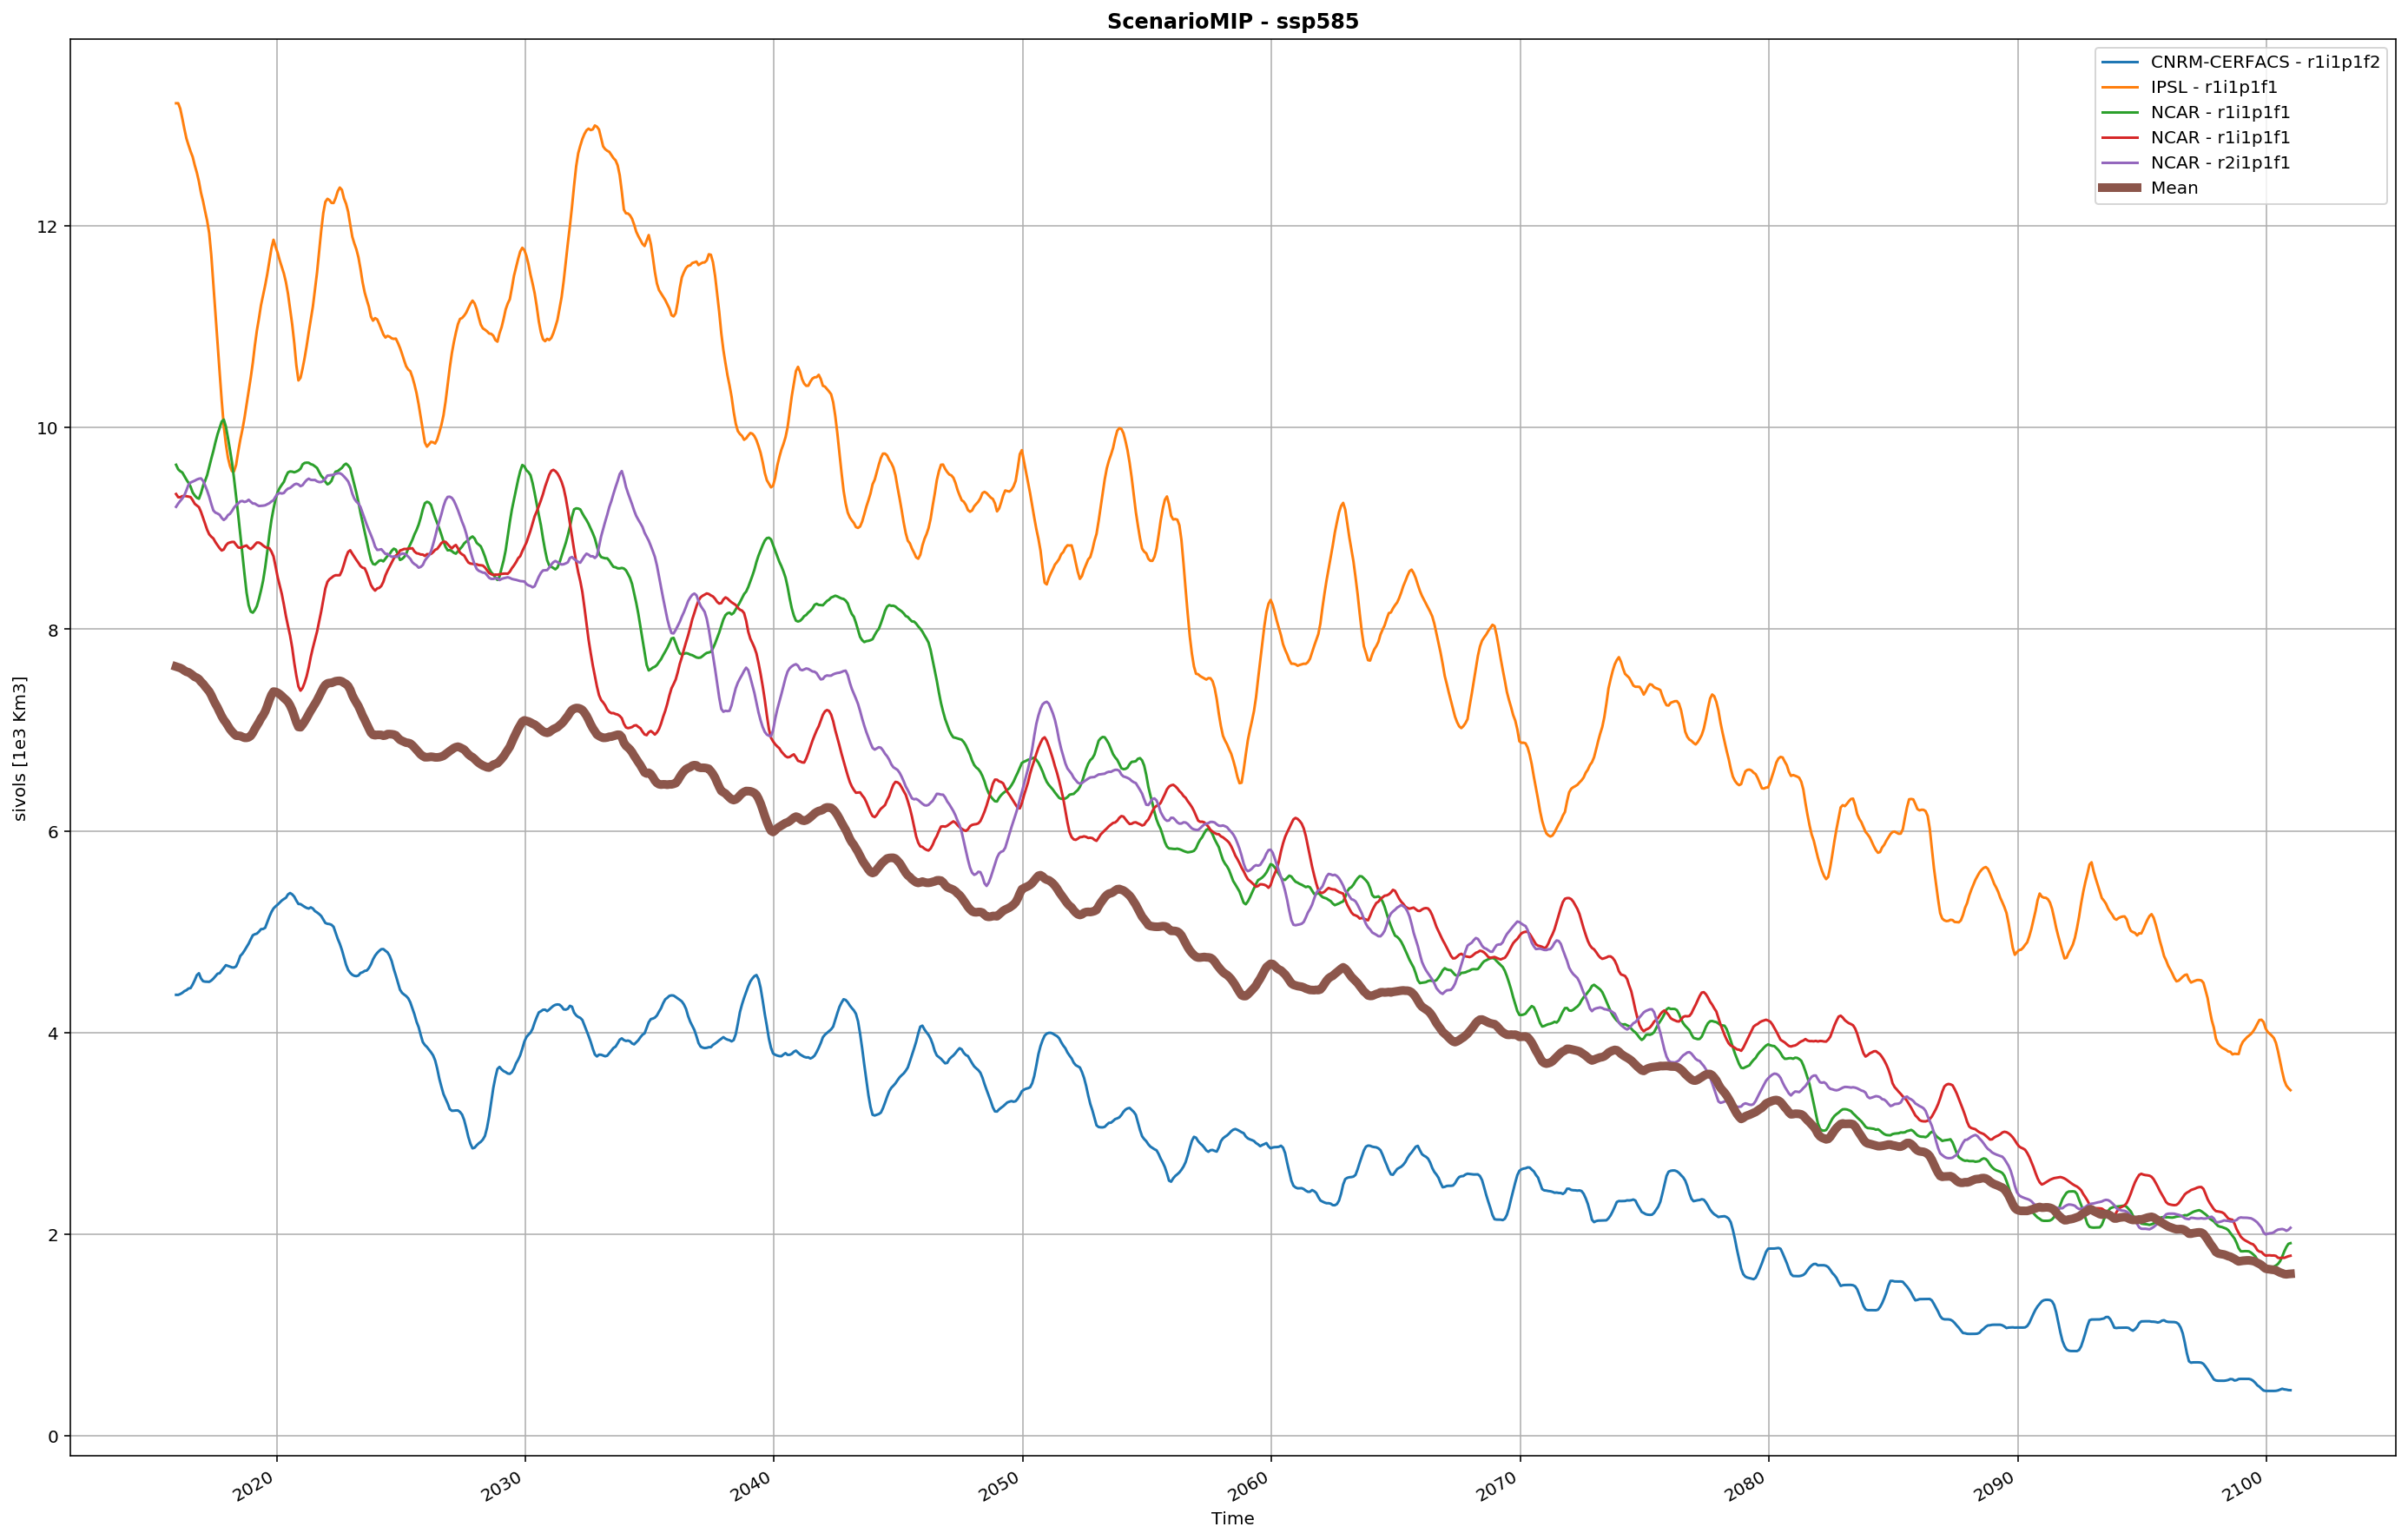

In [6]:
# Plots of all models for each (variable_id , experiment_id) and their Mean Model (in bold)
timelines = np.zeros((1032,9))
n = 0

for variable_id in list_variable_id:
  for experiment_id in list_experiment_id:
    df_ta = df.query("table_id == @table_id & variable_id == @variable_id & activity_id== @activity_id & experiment_id == @experiment_id")
    zstore = df_ta.zstore.values
    institution = df_ta.institution_id.values
    member = df_ta.member_id.values

    temps = xr.open_zarr(gcs.get_mapper(zstore[0]), consolidated=True).time.values
    total_sum = np.zeros((1032,))

    plt.figure(figsize=(24,15))
    for i in range(len(df_ta)):
      mapper = gcs.get_mapper(zstore[i])
      ds = xr.open_zarr(mapper, consolidated=True)
      ds.time.values = temps
      dims = [j for j in ds[variable_id].dims if j!='time']
      if dims: timeseries = ds[variable_id].mean(dim=[dims[0],dims[1]])
      else: timeseries = ds[variable_id]
      if timeseries.mean()<1e6:
        timeseries.rolling(time=12).mean().plot(label=institution[i]+' - '+member[i])
        total_sum += timeseries.values.reshape((-1,))

    timeseries.values = total_sum/(i+1)
    timeline = timeseries.rolling(time=12).mean()
    timelines[:,n] = timeline.values
    n += 1
    timeline.plot(label='Mean',linewidth=5)
    plt.legend(); plt.grid(); plt.title(activity_id+' - '+experiment_id, fontweight="bold")
    plt.xlabel('Time'), plt.ylabel(variable_id+' '+y[variable_id])

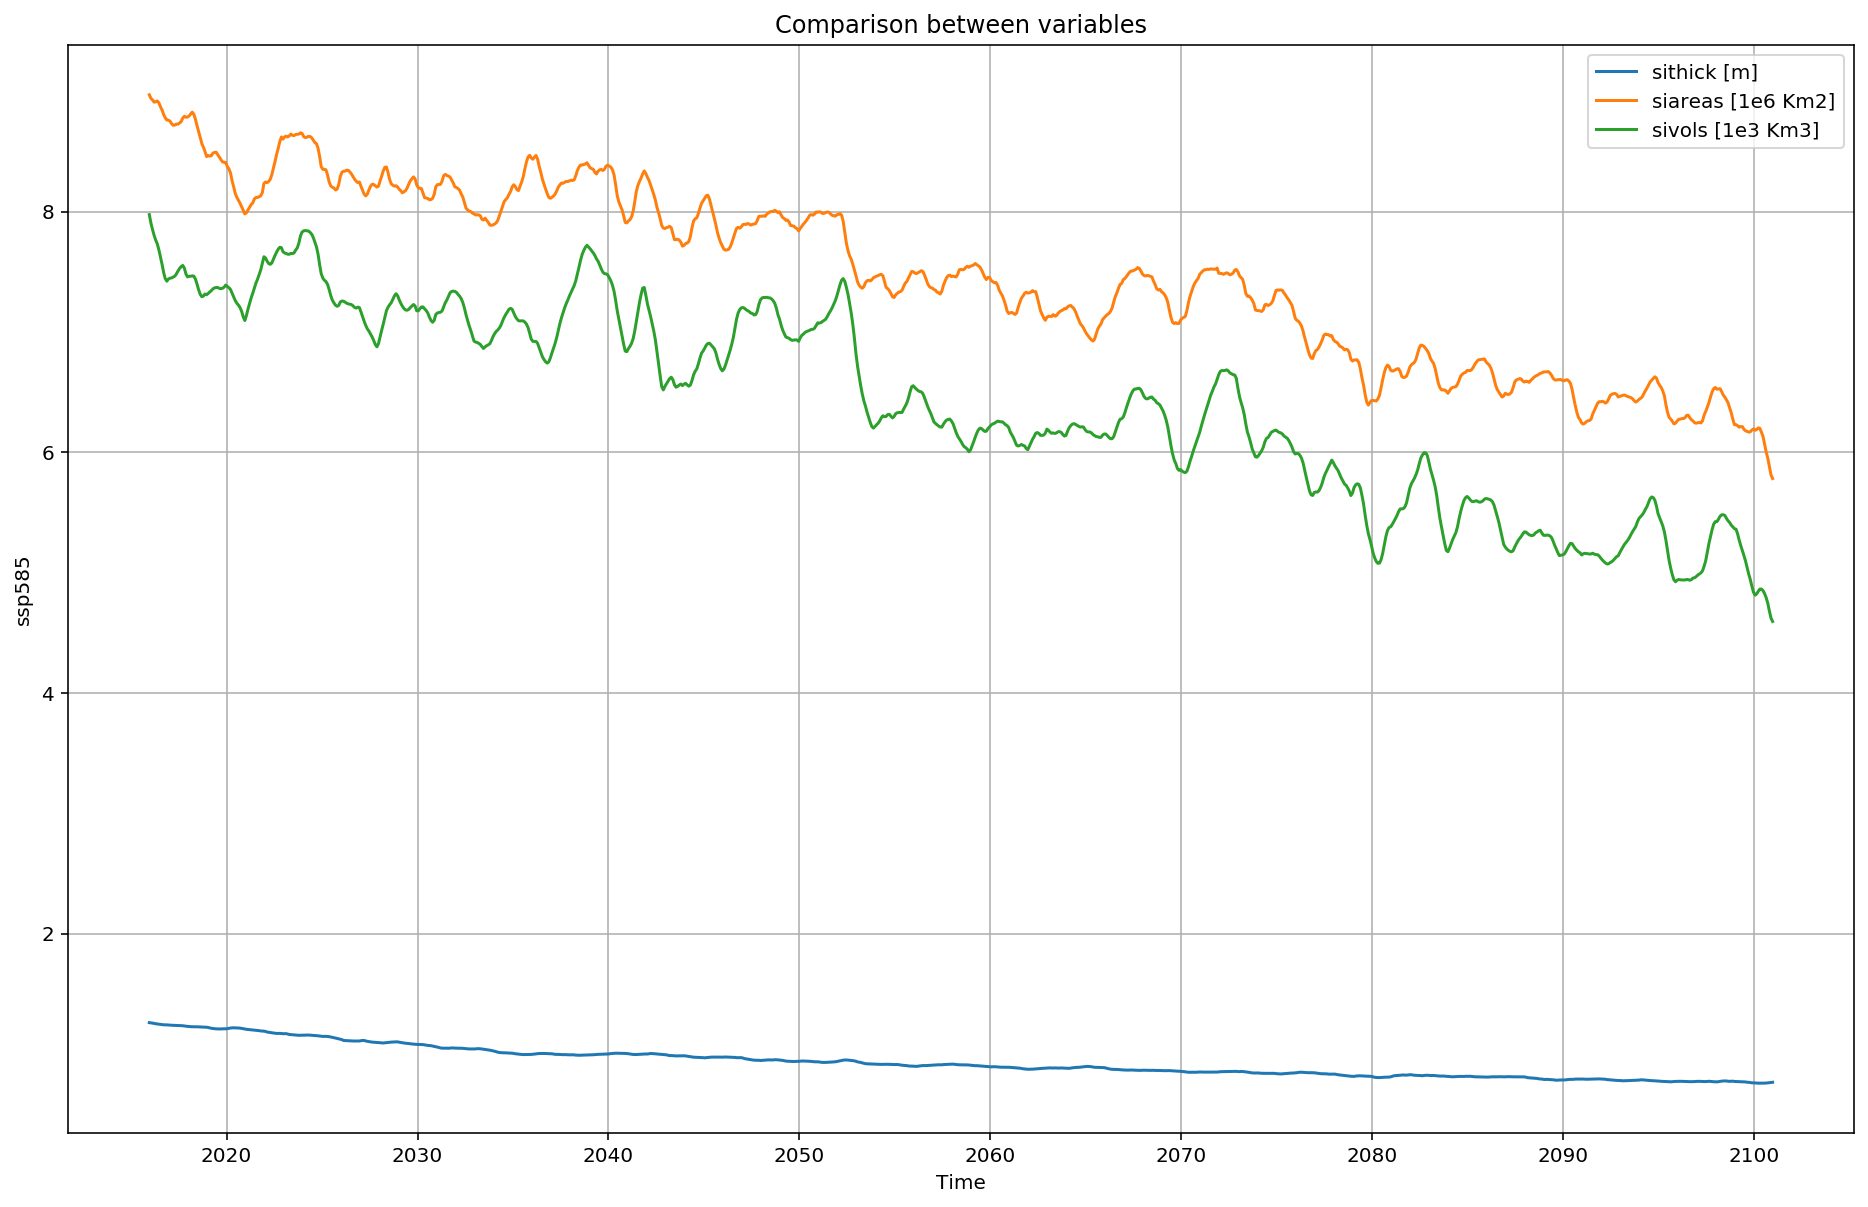

In [7]:
#Plot of the three Mean Models for each variable
plt.figure(figsize=(16,10))
j = 0
for i in range(6,9):
  plt.plot(temps, timelines[:,j*3+1], label=list_variable_id[j]+' '+y[list_variable_id[j]])
  j+=1
  plt.xlabel('Time'); plt.ylabel(list_experiment_id[2]);
  plt.title('Comparison between variables')
  plt.legend(); plt.grid(); 

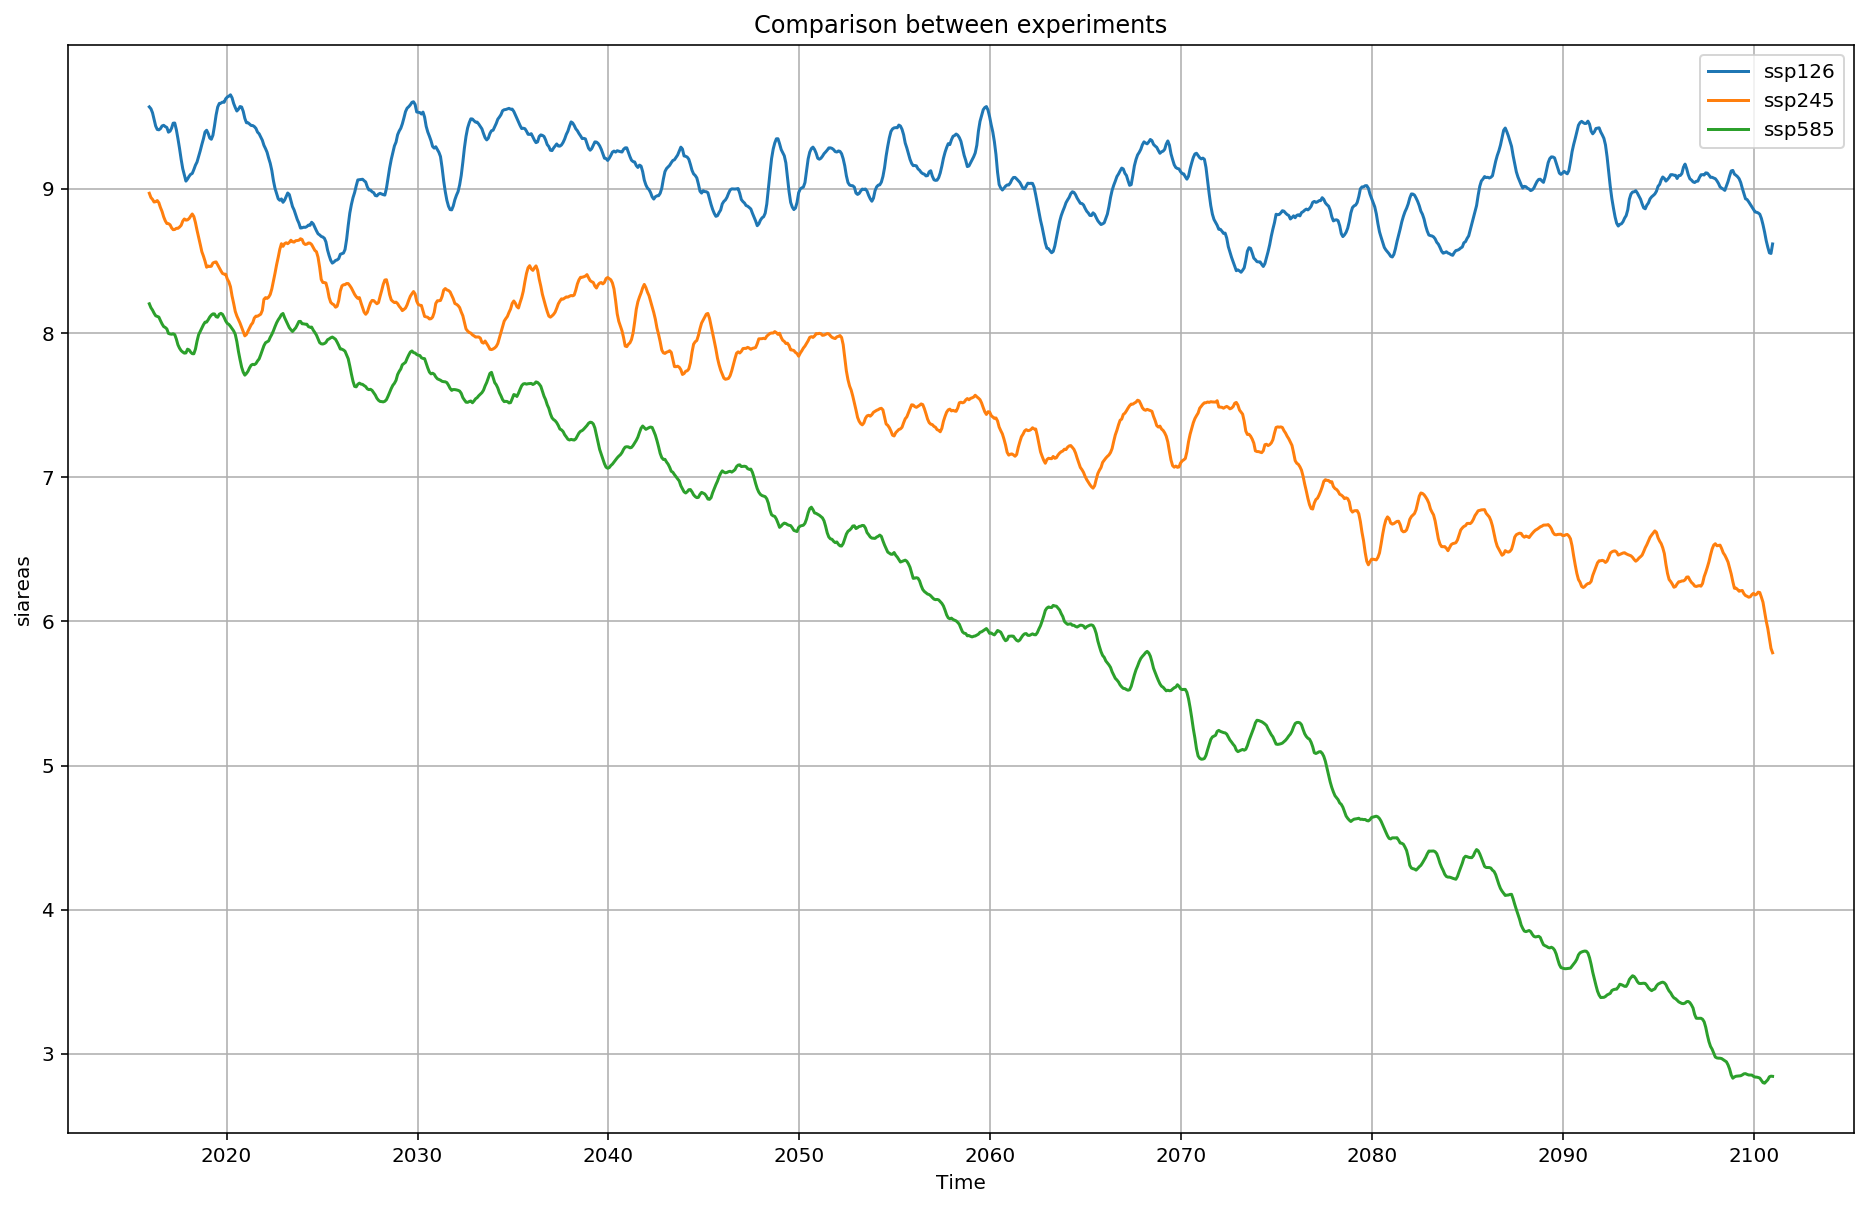

In [8]:
#Comparison between different experiences for the Sea Ice Area variable
plt.figure(figsize=(16,10))
j = 0
for i in range(3,6):
  plt.plot(temps, timelines[:,i], label=list_experiment_id[j])
  j+=1
  plt.xlabel('Time'); plt.ylabel(list_variable_id[1]);
  plt.title('Comparison between experiments')
  plt.legend(); plt.grid(); 

## Maps

In [9]:
!apt-get -qq install python-cartopy python3-cartopy

Selecting previously unselected package python-pkg-resources.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../5-pyth

In [0]:
# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


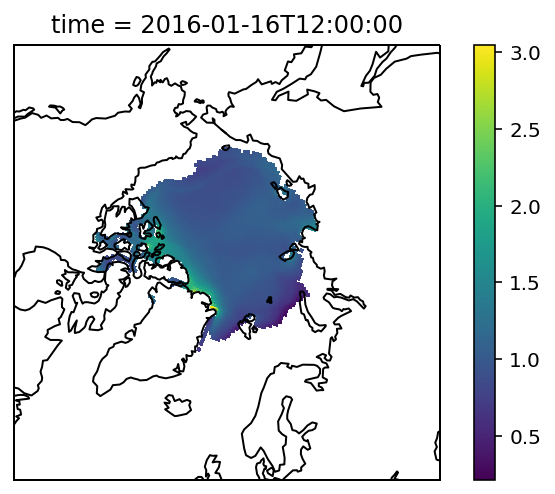

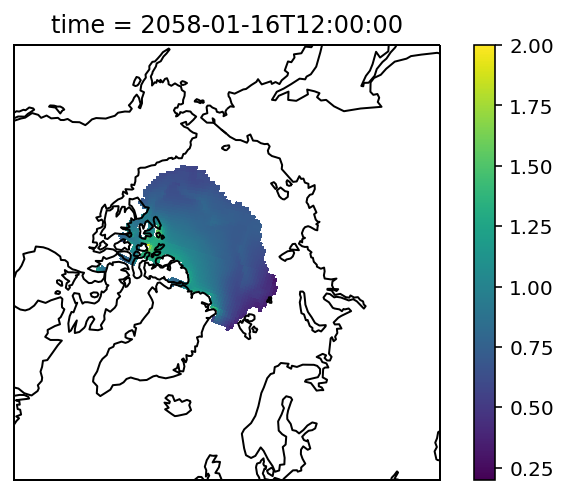

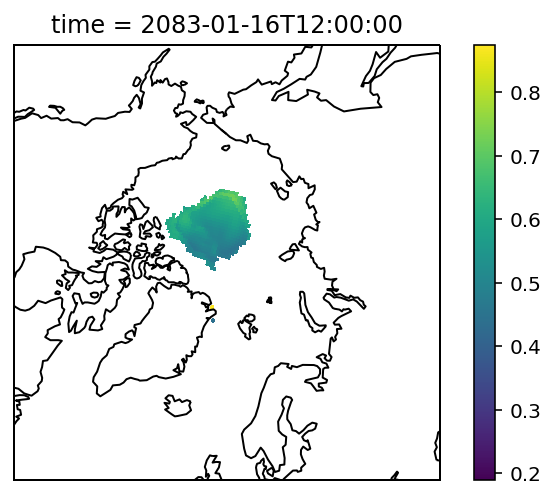

In [18]:
variable_id = 'sithick'; experiment_id = 'ssp585'
df_ta = df.query("table_id == @table_id & variable_id == @variable_id & activity_id== @activity_id & experiment_id == @experiment_id")
ds = xr.open_zarr(gcs.get_mapper(df_ta.zstore.values[0]), consolidated=True)

plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ds[variable_id].rolling(time=12).mean()[12].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='lon', y='lat', add_colorbar=True); 
ax.coastlines();

plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ds[variable_id].rolling(time=12).mean()[516].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='lon', y='lat', add_colorbar=True); 
ax.coastlines();

plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ds[variable_id].rolling(time=12).mean()[816].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='lon', y='lat', add_colorbar=True); 
ax.coastlines();